# INSTRUCTIONS PROVIDED:

## PRODUCTION:
Dataset containing PLC information on the processing settings at COIL-DATE-MT level.
1. `COIL ID`: of the metal coil processed
1. `MT`:meter observation of the coil (i.e. one observation every 7 meters)
1. `DATE`: day of the year in which the processing of a given COIL-MT started
1. `TIME_START_PROCESS`: time in which the processing started 
1. All the remaining fields are settings refering to the processing of a given COIL-MT.

Hint: check the reliability of the MT variable.

## DEFECTS:
Dataset containing information on the detected defect by coil and type of defect.

This information are gathered during quality control processes after the production.
1. `COIL ID`: of the metal coil processed
1. `MT_FROM`: point of the coil in which a given defect start.
1. `MT_TO`: point in which a given defect end.
1. `DATE`: date in which the coil has been processed.
1. `DIF_TIPO_1`(to6): indicator for the kind of of defect detected.

In [1]:
#imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, make_scorer, hamming_loss, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Memory
from sklearn.multioutput import MultiOutputClassifier
import csv
random_state = 42
test_size = 0.4
cachedir = Memory(location='cache_directory', verbose=0)

In [2]:
#loading data
path_production= '/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_PRODUCTION_clean.csv'
path_defects='/Users/mattia/Library/CloudStorage/OneDrive-Personal/BBS/05 Machine learnign/00 Fieldwork/4_MANUFACTURING_ROOT CAUSE/RC_DEFECTS_clean.csv'
production = pd.read_csv(path_production)
defects = pd.read_csv(path_defects, sep=';')

In [3]:
#Data observation
print(production.info())
production.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299384 entries, 0 to 299383
Columns: 110 entries, COIL to FILL_BENDING_NEG
dtypes: float64(107), int64(1), object(2)
memory usage: 251.3+ MB
None


,COIL,DATE,MT,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0.0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7.0,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14.0,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21.0,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28.0,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(defects.info())
defects.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COIL        617 non-null    int64 
 1   MT_FROM     617 non-null    int64 
 2   MT_TO       617 non-null    int64 
 3   DATE        617 non-null    object
 4   DIF_TIPO_1  617 non-null    int64 
 5   DIF_TIPO_2  617 non-null    int64 
 6   DIF_TIPO_3  617 non-null    int64 
 7   DIF_TIPO_4  617 non-null    int64 
 8   DIF_TIPO_5  617 non-null    int64 
 9   DIF_TIPO_6  617 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 48.3+ KB
None


,COIL,MT_FROM,MT_TO,DATE,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
0,389523,0,599,01/03/19,0,0,1,0,0,0
1,389523,600,1457,01/03/19,0,1,1,0,0,0
2,389528,0,1399,01/03/19,0,0,1,0,0,0
3,389528,1400,1539,01/03/19,0,0,1,0,1,0
4,389712,0,1374,01/03/19,0,0,1,0,0,0


Creating the `MT_REVIEWED` column and substitute with the `MT` for correcting the data issues

In [5]:
production.sort_values(by=['COIL', 'DATE', 'TIME_START_PROCESS'], inplace=True)
production['MT_REVIEWED'] = production.groupby(['COIL'])['MT'].transform(lambda x: np.arange(start=0, stop=len(x)*7, step=7))
production.drop(columns=['MT'], inplace=True)
column_change=production.pop('MT_REVIEWED')
production.insert(2, 'MT_REVIEWED',column_change)
production.head()

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,240627,2019-03-15,0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240627,2019-03-15,7,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240627,2019-03-15,14,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240627,2019-03-15,21,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,240627,2019-03-15,28,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,530.110125,14.625,14.625,1956.40875,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(f"Unique COIL values in 'production' dataset: {production['COIL'].nunique()}")
print(f"Unique COIL values in 'defects' dataset: {defects['COIL'].nunique()}")
print(f"Percentage of COILS with defects: {((defects['COIL'].nunique())/(production['COIL'].nunique()))*100:.2f}%")

Unique COIL values in 'production' dataset: 1261
Unique COIL values in 'defects' dataset: 534
Percentage of COILS with defects: 42.35%


Number of missing values in MT: 0


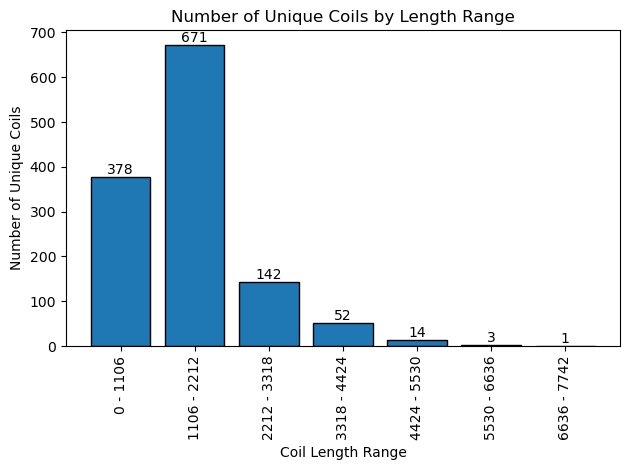

In [7]:
mt_values = production["MT_REVIEWED"]
print(f"Number of missing values in MT: {mt_values.isna().sum()}")
coil_lengths = production.groupby('COIL')['MT_REVIEWED'].agg(lambda x: x.max() - x.min())
num_bins = 7
max_length = coil_lengths.max()
bin_edges = np.linspace(0, max_length, num_bins + 1)
bin_edges = np.round(bin_edges).astype(int) 

bins = pd.cut(coil_lengths, bins=bin_edges)
bin_counts = bins.value_counts().sort_index()

fig, ax = plt.subplots()
bars = ax.bar(range(len(bin_counts)), bin_counts.values, edgecolor='black')

plt.title("Number of Unique Coils by Length Range")
plt.xlabel("Coil Length Range")
plt.ylabel("Number of Unique Coils")
plt.xticks(range(len(bin_counts)), [str(interval) for interval in bin_counts.index], rotation=90)
bin_labels = [f"{int(left)} - {int(right)}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]
plt.xticks(range(len(bin_counts)), bin_labels, rotation=90)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [8]:
defects_coils_in_production = defects['COIL'].isin(production['COIL'])
all_coils_present = defects_coils_in_production.all()
print(f"All 'COIL' values in 'defects' are present in 'production': {all_coils_present}")
if not all_coils_present:
    missing_coils = defects.loc[~defects_coils_in_production, 'COIL'].unique()
    print(f"'COIL' values in 'defects' not present in 'production': {missing_coils}")

All 'COIL' values in 'defects' are present in 'production': True


In [9]:
# # Code working for excluding the rows with no defects in the production dataset

# # Create a new column in defects to facilitate the merge
# defects['MT'] = defects.apply(lambda x: list(range(x['MT_FROM'], x['MT_TO']+1)), axis=1)

# # Explode the 'MT' column to create a row for each meter within the defect range
# defects_exploded = defects.explode('MT')

# # Perform the merge on 'COIL' and 'MT'
# merged_df = pd.merge(production, defects_exploded, on=['COIL', 'MT'], how='left', suffixes=('', '_defects'))

# # Now, we need to fill in the defect information for the rows where the defects are present
# # We will create a mask that identifies rows where a defect starts and propagate the defect information forward
# for col in ['DATE', 'DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']:
#     # Forward-fill the defect information for each COIL group
#     merged_df[col] = merged_df.groupby('COIL')[col].ffill()

# # Filter out the rows where 'MT' is less than 'MT_FROM' and greater than 'MT_TO'
# merged_df = merged_df[(merged_df['MT'] >= merged_df['MT_FROM']) & (merged_df['MT'] <= merged_df['MT_TO'])]

# # Now merged_df should have the defect information and date in the correct rows



## Merging 2 dataframes
For the merging we looked for keeping all the rows of the production df

In [10]:
# This code creates the new dataframe with the defect information applied to the relevant meter ranges.
merged_df = production.copy()
for i in range(1, 7):
    defect_col = f'DIF_TIPO_{i}'
    merged_df[defect_col] = 0 # or use np.nan, or 0, depending on how you want to represent no defect

def apply_defects(row, production, merged_df):
    coil_id = row['COIL']
    mt_from = row['MT_FROM']
    mt_to = row['MT_TO']
    defect_info = row[['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']]
    
    # Filter production for the current coil and meter range
    mask = (production['COIL'] == coil_id) & (production['MT_REVIEWED'] >= mt_from) & (production['MT_REVIEWED'] <= mt_to)
    production_subset = production.loc[mask]
    
    # Update the merged DataFrame with defect information
    for index in production_subset.index:
        merged_df.loc[index, defect_info.index] = defect_info.values

# Apply defects to the production DataFrame
_=defects.apply(lambda row: apply_defects(row, production, merged_df), axis=1)

In [11]:
print(merged_df.shape)
merged_df.head()
#same number of rows as the production dataset

(299384, 116)


,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
0,240627,2019-03-15,0,14:25:23.060,16.934625,671.967562,679.751438,688.119187,716.717250,734.616563,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,240627,2019-03-15,7,14:25:53.060,16.773638,668.635875,676.207125,681.034500,710.093250,729.040500,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,240627,2019-03-15,14,14:26:23.060,11.142165,669.105375,677.042625,678.493125,707.967750,727.783500,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,240627,2019-03-15,21,14:27:08.060,11.148851,671.631750,681.066000,679.704750,707.241375,727.886250,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,240627,2019-03-15,28,14:27:38.060,15.657188,675.052875,686.972813,683.336250,710.432437,730.182375,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [12]:
print(f"Number of errors Type_1: {merged_df['DIF_TIPO_1'].value_counts().get(1, 0)}")
print(f"Number of errors Type_2: {merged_df['DIF_TIPO_2'].value_counts().get(1, 0)}")
print(f"Number of errors Type_3: {merged_df['DIF_TIPO_3'].value_counts().get(1, 0)}")
print(f"Number of errors Type_4: {merged_df['DIF_TIPO_4'].value_counts().get(1, 0)}")
print(f"Number of errors Type_5: {merged_df['DIF_TIPO_5'].value_counts().get(1, 0)}")
print(f"Number of errors Type_6: {merged_df['DIF_TIPO_6'].value_counts().get(1, 0)}")

Number of errors Type_1: 6746
Number of errors Type_2: 10044
Number of errors Type_3: 86634
Number of errors Type_4: 51883
Number of errors Type_5: 7589
Number of errors Type_6: 7217


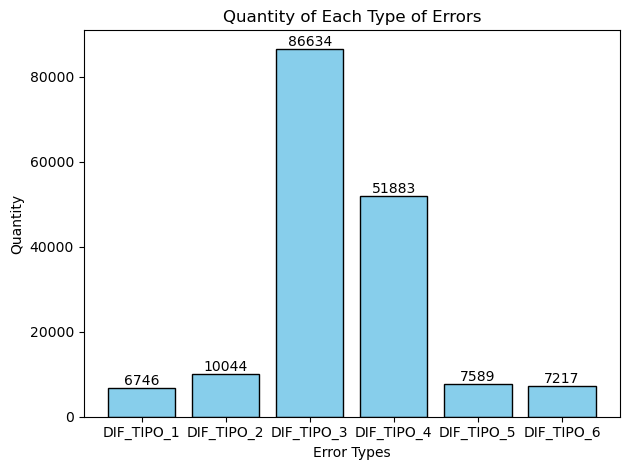

In [13]:
error_counts = {}

for i in range(1, 7):
    error_type = f'DIF_TIPO_{i}'
    error_counts[error_type] = merged_df[error_type].value_counts().get(1, 0)

error_types = list(error_counts.keys())
counts = list(error_counts.values())

plt.bar(error_types, counts, color='skyblue', edgecolor='black')

plt.title("Quantity of Each Type of Errors")
plt.xlabel("Error Types")
plt.ylabel("Quantity")

for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Dropping rows with NaN values in features

In [14]:
nan_counts = merged_df.isnull().sum()
columns_with_nans = nan_counts[nan_counts > 0].index.tolist()
dropped_df = merged_df.dropna(subset=columns_with_nans)
dropped_df

,COIL,DATE,MT_REVIEWED,TIME_START_PROCESS,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,...,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
170,243941,2019-03-06,28,00:02:59.070,23.610352,1273.28850,1279.944000,1281.003750,1280.850750,1313.777250,...,1224.573750,0.035063,0.258854,0.134993,0,0,0,0,0,0
171,243941,2019-03-06,35,00:03:14.070,23.570531,1272.81000,1280.896875,1282.756875,1280.227500,1310.394375,...,1282.893750,0.026615,0.258924,0.135011,0,0,0,0,0,0
172,243941,2019-03-06,42,00:03:44.070,23.591655,1272.04650,1280.596500,1283.728500,1280.731500,1309.549500,...,1290.660000,0.034612,0.258888,0.135006,0,0,0,0,0,0
173,243941,2019-03-06,49,00:03:59.070,23.583060,1270.78875,1279.190250,1284.021000,1280.661750,1308.818250,...,1289.478750,0.039367,0.258924,0.135024,0,0,0,0,0,0
174,243941,2019-03-06,56,00:04:14.070,23.594212,1269.96750,1277.968125,1284.232500,1281.303750,1308.823125,...,1326.228750,0.038277,0.258899,0.135018,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299365,6838679,2019-04-19,749,10:46:32.860,8.932843,1271.34000,1277.043750,1259.679375,1262.975625,1276.233750,...,1646.521875,0.034937,0.258947,0.135017,0,0,0,0,0,0
299366,6838679,2019-04-19,756,10:47:32.860,8.948430,1267.99875,1278.011250,1261.586250,1267.042500,1278.022500,...,1674.438750,0.038531,0.258911,0.134953,0,0,0,0,0,0
299367,6838679,2019-04-19,763,10:48:17.860,8.951884,1269.88875,1279.816875,1264.786875,1270.957500,1283.366250,...,1666.507500,0.038778,0.258913,0.135053,0,0,0,0,0,0
299368,6838679,2019-04-19,770,10:49:17.860,8.977444,1266.59250,1280.936250,1265.782500,1271.475000,1285.683750,...,1671.665625,0.035091,0.258892,0.135005,0,0,0,0,0,0


In [15]:
print(f"Number of errors Type_1: {dropped_df['DIF_TIPO_1'].value_counts().get(1, 0)}")
print(f"Number of errors Type_2: {dropped_df['DIF_TIPO_2'].value_counts().get(1, 0)}")
print(f"Number of errors Type_3: {dropped_df['DIF_TIPO_3'].value_counts().get(1, 0)}")
print(f"Number of errors Type_4: {dropped_df['DIF_TIPO_4'].value_counts().get(1, 0)}")
print(f"Number of errors Type_5: {dropped_df['DIF_TIPO_5'].value_counts().get(1, 0)}")
print(f"Number of errors Type_6: {dropped_df['DIF_TIPO_6'].value_counts().get(1, 0)}")

Number of errors Type_1: 6174
Number of errors Type_2: 8678
Number of errors Type_3: 77925
Number of errors Type_4: 47572
Number of errors Type_5: 6680
Number of errors Type_6: 6583


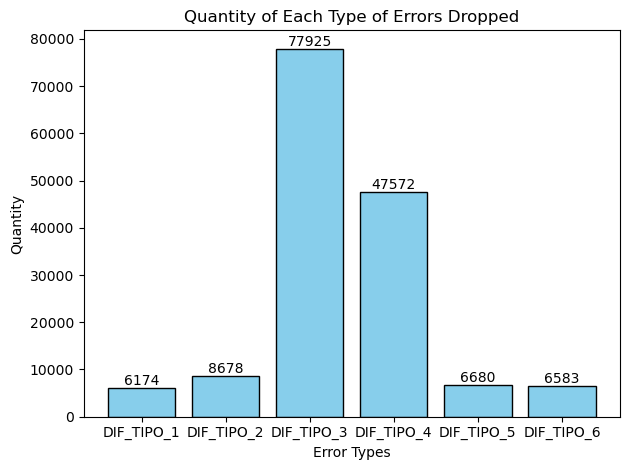

In [16]:
error_counts_drop = {}

for i in range(1, 7):
    error_type_drop = f'DIF_TIPO_{i}'
    error_counts_drop[error_type_drop] = dropped_df[error_type_drop].value_counts().get(1, 0)

error_types_drop = list(error_counts_drop.keys())
counts_drop = list(error_counts_drop.values())

plt.bar(error_types_drop, counts_drop, color='skyblue', edgecolor='black')

plt.title("Quantity of Each Type of Errors Dropped")
plt.xlabel("Error Types")
plt.ylabel("Quantity")

for i, count_drop in enumerate(counts_drop):
    plt.text(i, count_drop + 0.05, str(count_drop), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [17]:
X=dropped_df.loc[:, 'SPEED_PROCESS':'FILL_BENDING_NEG']
print(X.shape)
X.head()

(260638, 106)


,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,PYRO_1_PRECHMBR,PYRO_2_FRST_3_ZONE,PYRO_3_LST_3_ZONE,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
170,23.610352,1273.28850,1279.944000,1281.003750,1280.85075,1313.777250,1287.848250,867.159450,1100.796300,1143.731250,...,0.000000,0.000000,0.000,4244.88375,7.752319,198.895500,1224.57375,0.035063,0.258854,0.134993
171,23.570531,1272.81000,1280.896875,1282.756875,1280.22750,1310.394375,1286.454375,866.311688,1100.555063,1142.737500,...,0.000000,19.993500,21.375,4242.94875,12.563663,231.608250,1282.89375,0.026615,0.258924,0.135011
172,23.591655,1272.04650,1280.596500,1283.728500,1280.73150,1309.549500,1284.502500,860.741550,1100.221200,1137.415500,...,530.302500,21.352500,21.375,4243.57875,12.157837,221.544375,1290.66000,0.034612,0.258888,0.135006
173,23.583060,1270.78875,1279.190250,1284.021000,1280.66175,1308.818250,1283.818500,855.048825,1107.692775,1140.646500,...,531.106875,21.231000,21.375,4244.62500,11.856412,224.306625,1289.47875,0.039367,0.258924,0.135024
174,23.594212,1269.96750,1277.968125,1284.232500,1281.30375,1308.823125,1284.369375,855.170625,1099.023750,1143.309375,...,530.163000,20.293537,21.375,4243.79250,11.638350,212.985000,1326.22875,0.038277,0.258899,0.135018


In [18]:
y=dropped_df.loc[:, 'DIF_TIPO_1':'DIF_TIPO_6']
print(y.shape)
y.head()

(260638, 6)


,DIF_TIPO_1,DIF_TIPO_2,DIF_TIPO_3,DIF_TIPO_4,DIF_TIPO_5,DIF_TIPO_6
170,0,0,0,0,0,0
171,0,0,0,0,0,0
172,0,0,0,0,0,0
173,0,0,0,0,0,0
174,0,0,0,0,0,0


In [19]:
num_attributes = X.shape[1]
num_plots = 10  # Number of attributes to plot at a time
num_figures = int(np.ceil(num_attributes / num_plots))


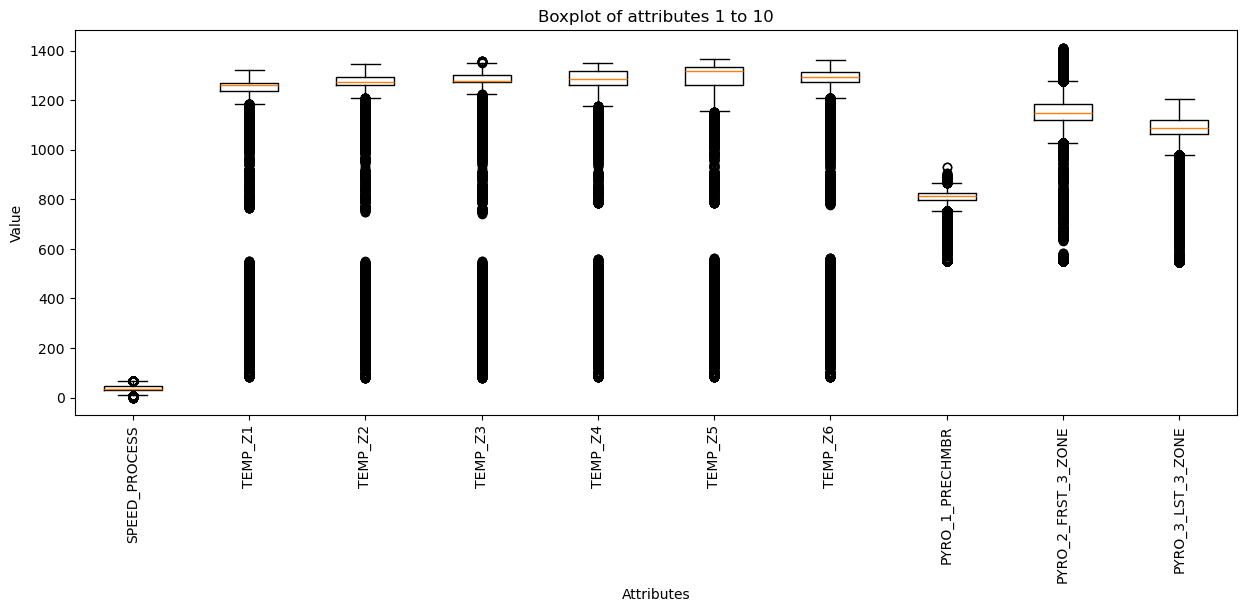

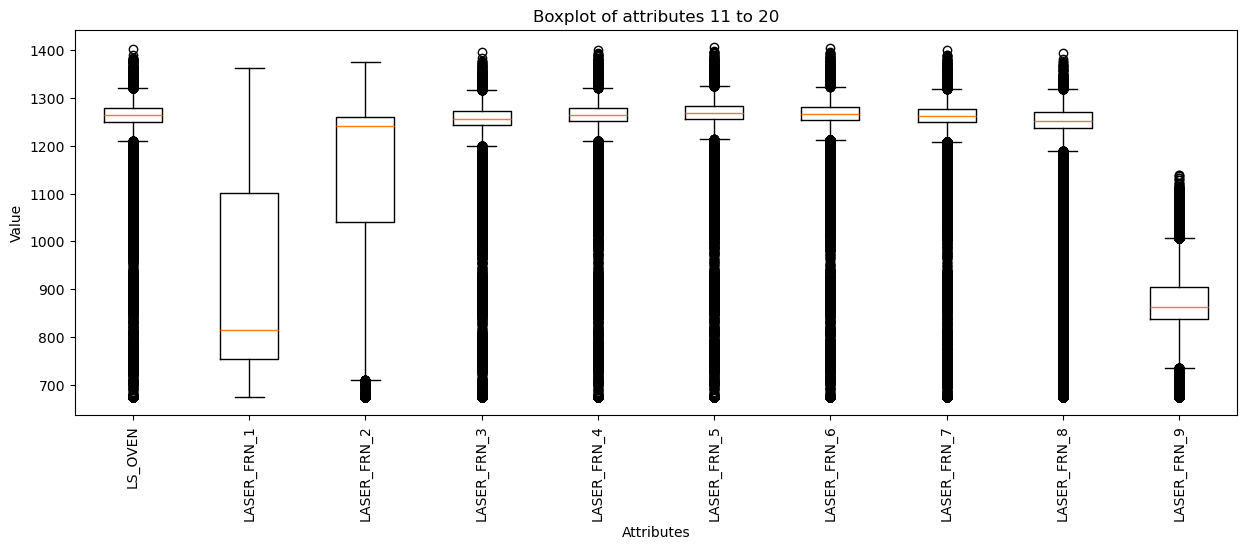

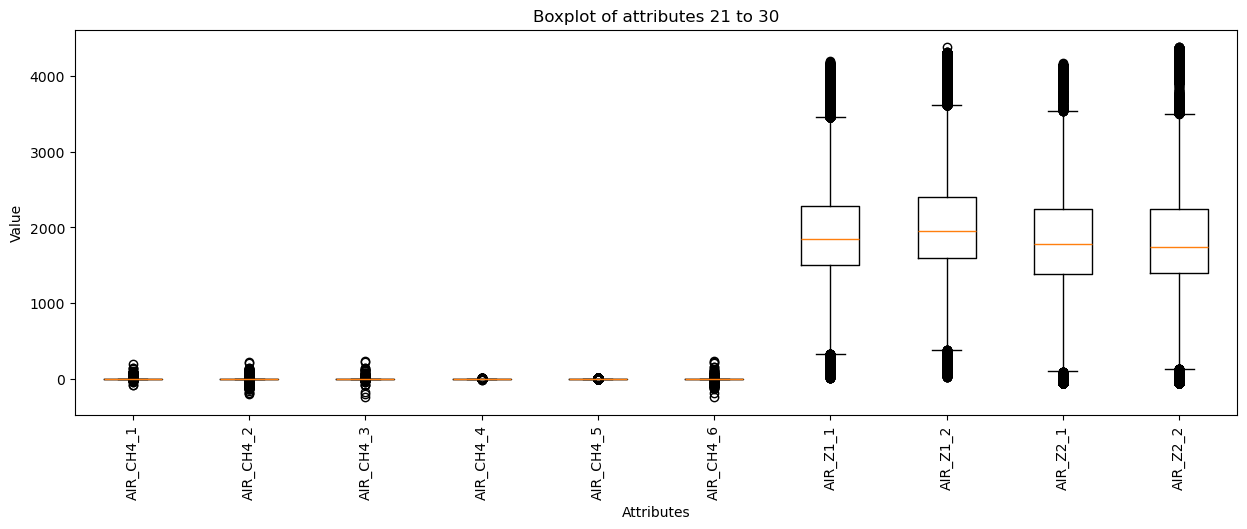

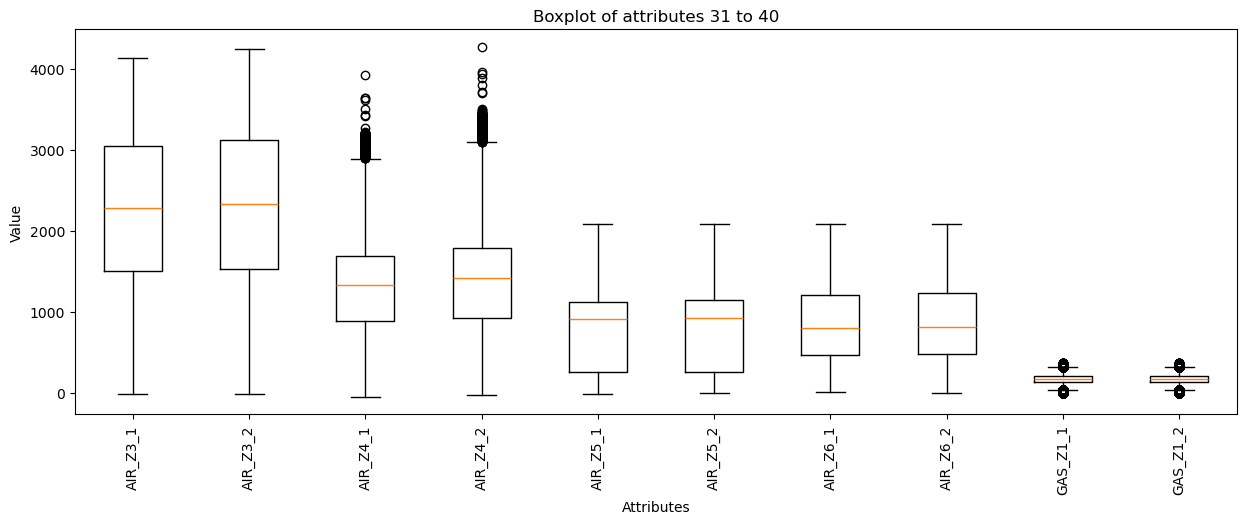

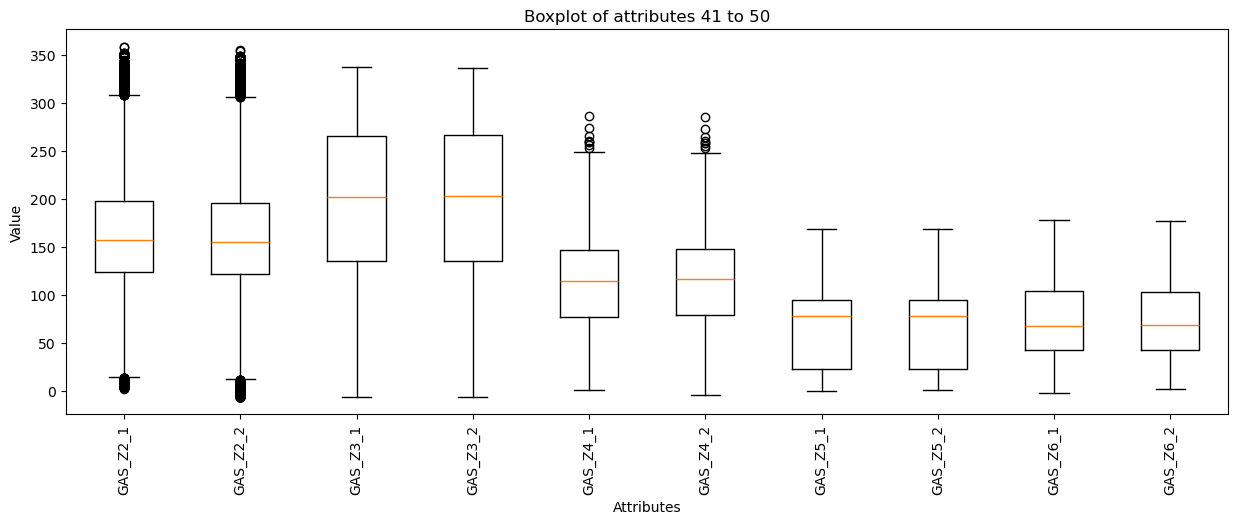

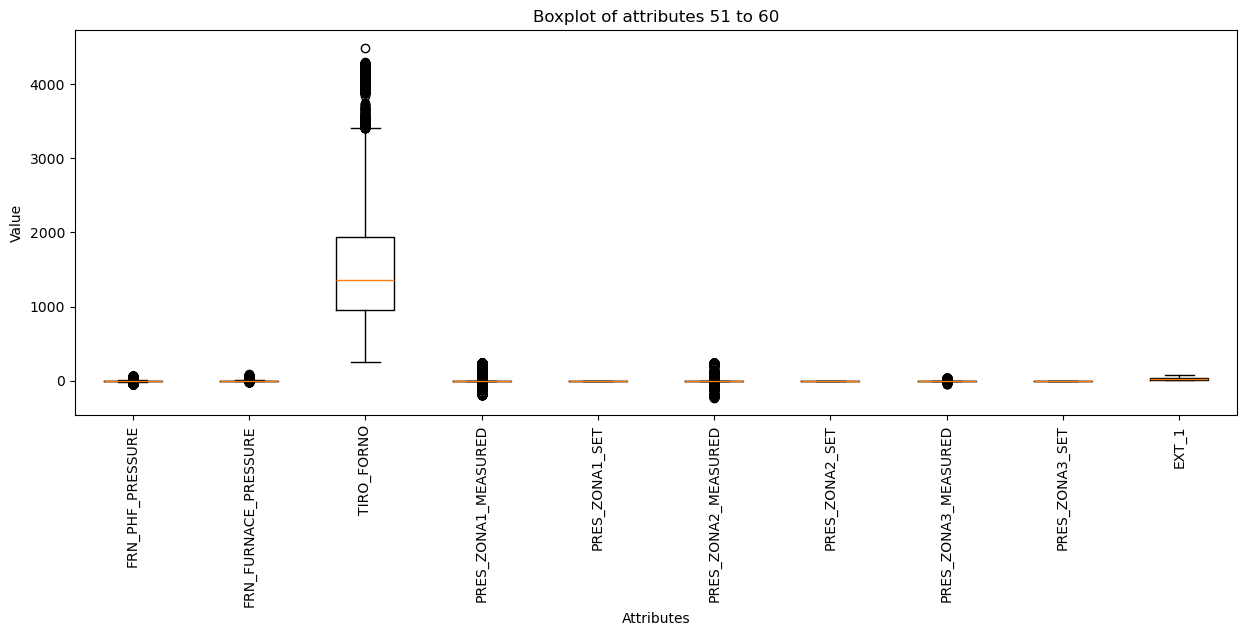

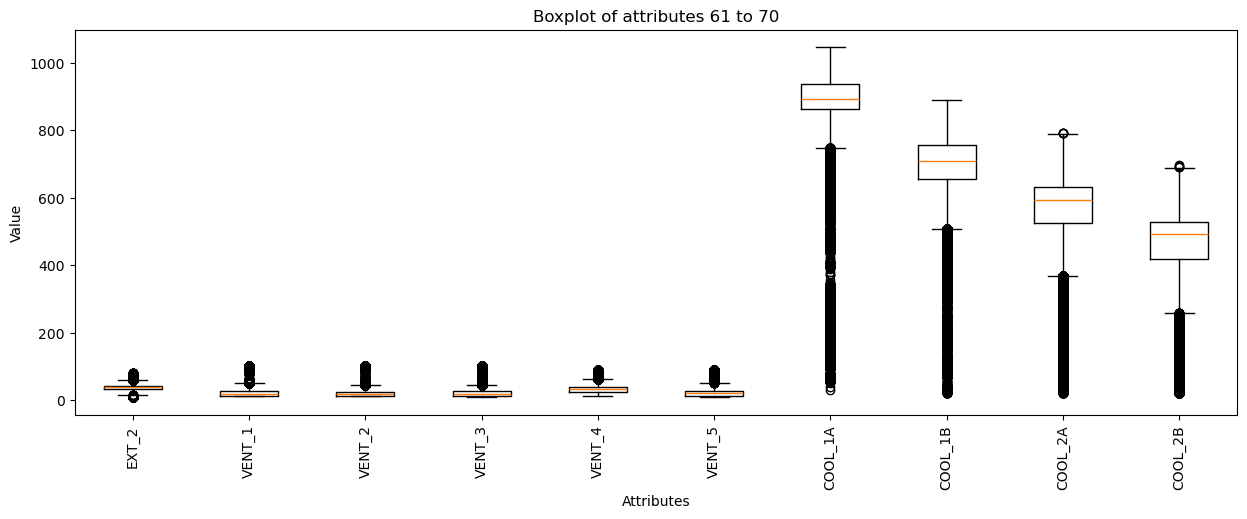

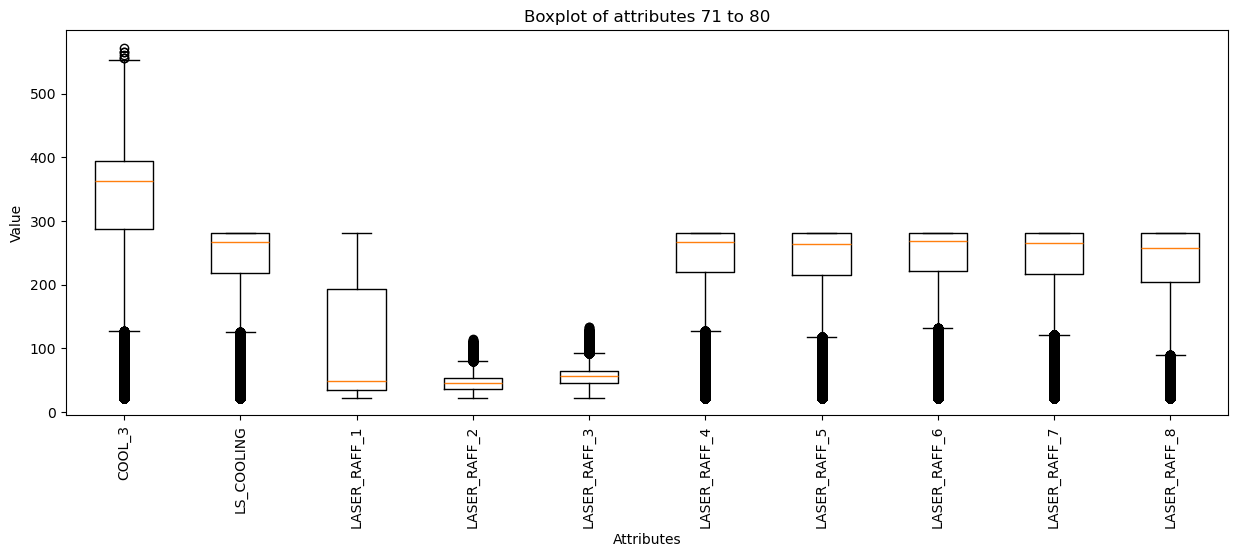

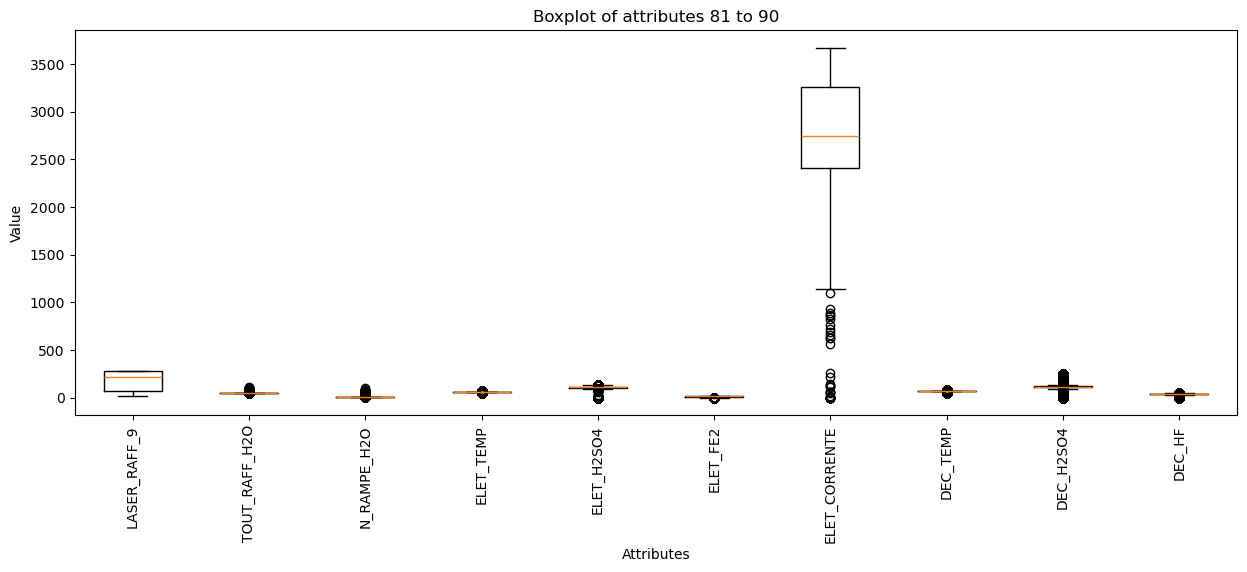

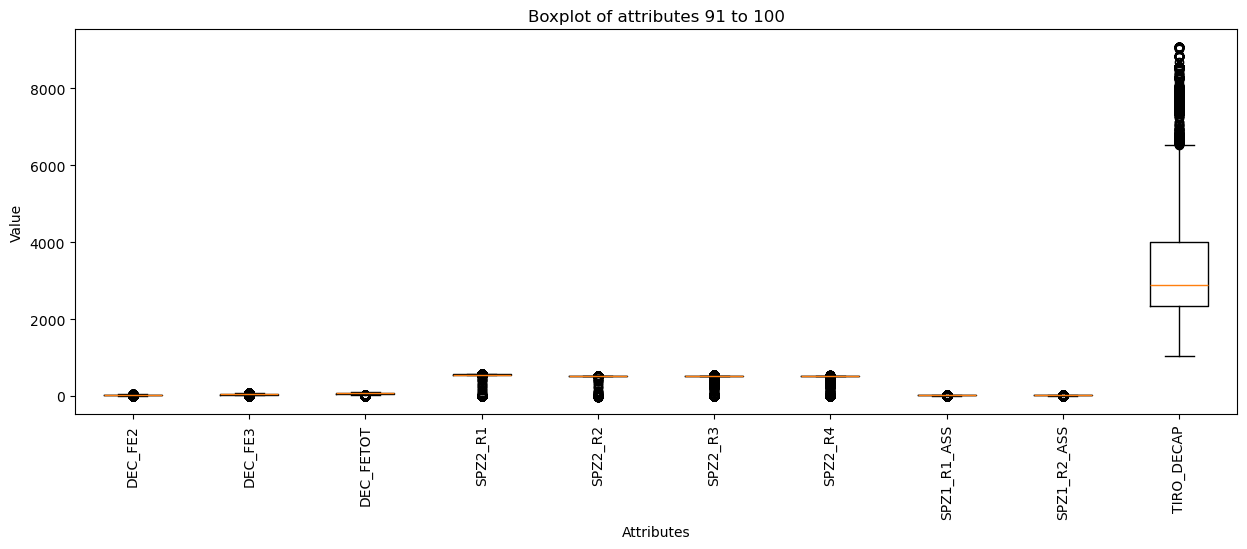

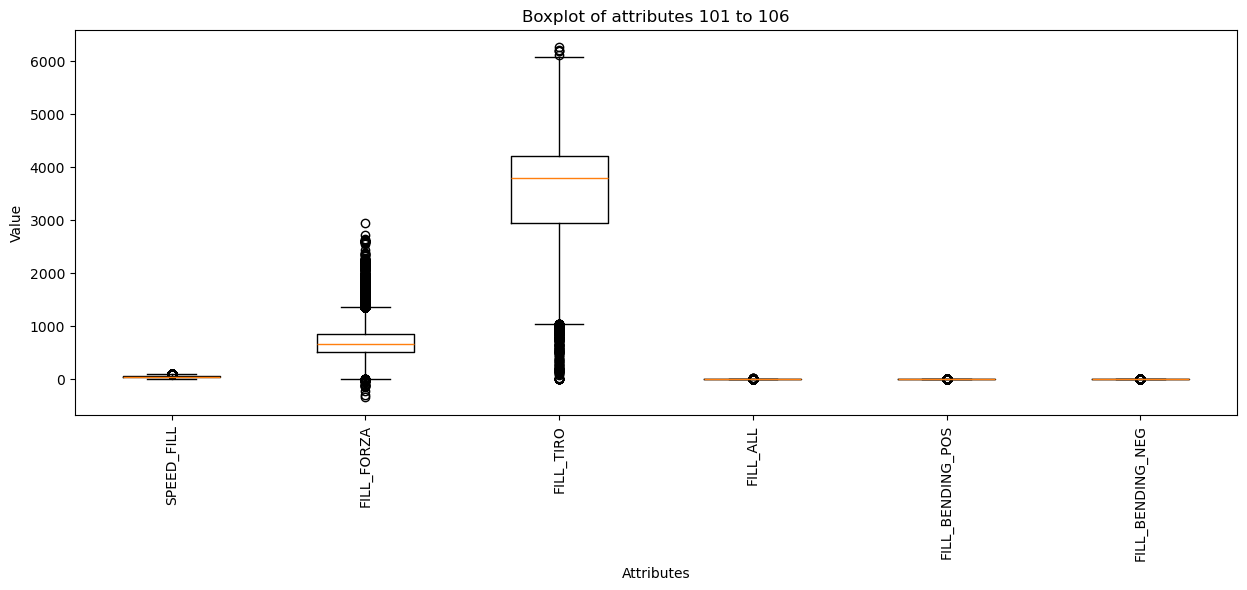

In [20]:

for i in range(num_figures):
    start_idx = i * num_plots
    end_idx = min((i + 1) * num_plots, num_attributes)
    plt.figure(figsize=(15, 5))  # Adjust the size as needed
    plt.boxplot(X.iloc[:, start_idx:end_idx])
    plt.title(f'Boxplot of attributes {start_idx + 1} to {end_idx}')
    plt.xlabel('Attributes')
    plt.ylabel('Value')
    plt.xticks(ticks=np.arange(1, end_idx - start_idx + 1), labels=X.columns[start_idx:end_idx], rotation=90)
    plt.show()

In [21]:
scaler = StandardScaler()
X_scl = scaler.fit_transform(X)
X_std = pd.DataFrame(X_scl, columns=X.columns)
X_std.head()


,SPEED_PROCESS,TEMP_Z1,TEMP_Z2,TEMP_Z3,TEMP_Z4,TEMP_Z5,TEMP_Z6,PYRO_1_PRECHMBR,PYRO_2_FRST_3_ZONE,PYRO_3_LST_3_ZONE,...,SPZ2_R4,SPZ1_R1_ASS,SPZ1_R2_ASS,TIRO_DECAP,SPEED_FILL,FILL_FORZA,FILL_TIRO,FILL_ALL,FILL_BENDING_POS,FILL_BENDING_NEG
0,-1.154669,0.420878,0.250654,0.166882,0.012251,0.225122,0.071440,1.678437,-0.621147,0.911261,...,-19.403961,-7.137570,-6.877373,0.819830,-1.873694,-1.768723,-2.429832,-2.158644,2.328861,-0.907238
1,-1.158260,0.415357,0.261554,0.186983,0.004908,0.186725,0.054815,1.656231,-0.624353,0.897538,...,-19.403961,0.629614,1.112279,0.818345,-1.592816,-1.651369,-2.370248,-2.195240,2.330587,-0.906771
2,-1.156355,0.406548,0.258118,0.198123,0.010846,0.177136,0.031535,1.510327,-0.628790,0.824044,...,0.105227,1.157565,1.112279,0.818829,-1.616507,-1.687472,-2.362313,-2.160598,2.329699,-0.906901
3,-1.157130,0.392037,0.242033,0.201477,0.010025,0.168836,0.023376,1.361213,-0.529502,0.868663,...,0.134819,1.110364,1.112279,0.819632,-1.634104,-1.677563,-2.363520,-2.140000,2.330587,-0.906434
4,-1.156124,0.382561,0.228054,0.203902,0.017589,0.168891,0.029947,1.364404,-0.644702,0.905435,...,0.100095,0.746174,1.112279,0.818993,-1.646834,-1.718178,-2.325973,-2.144722,2.329971,-0.906590


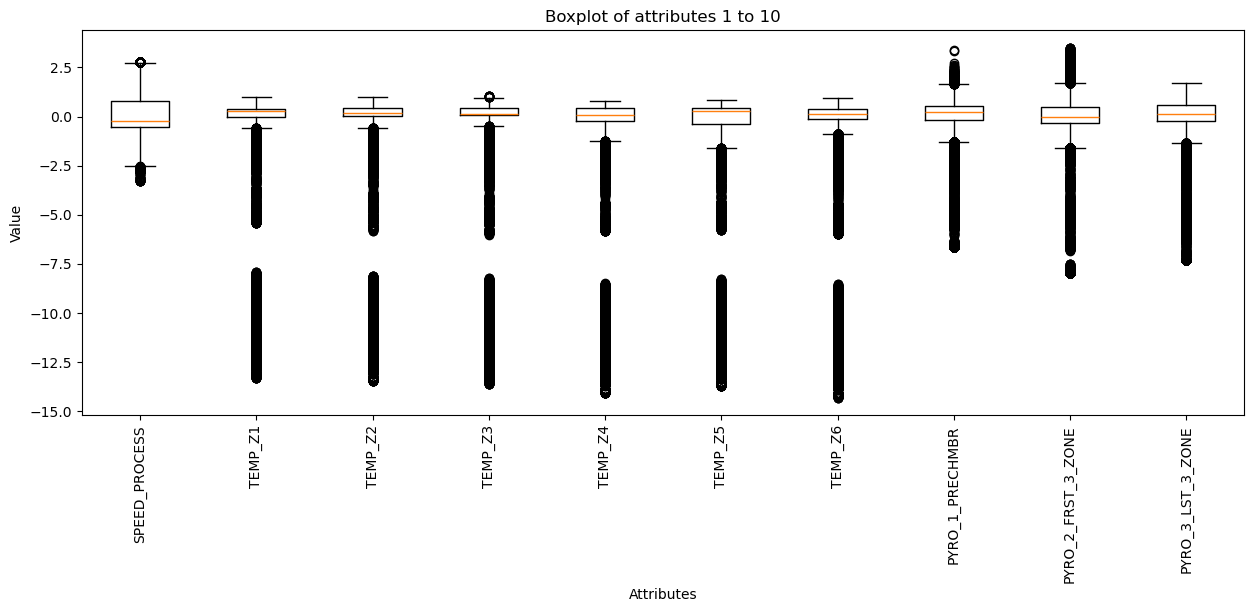

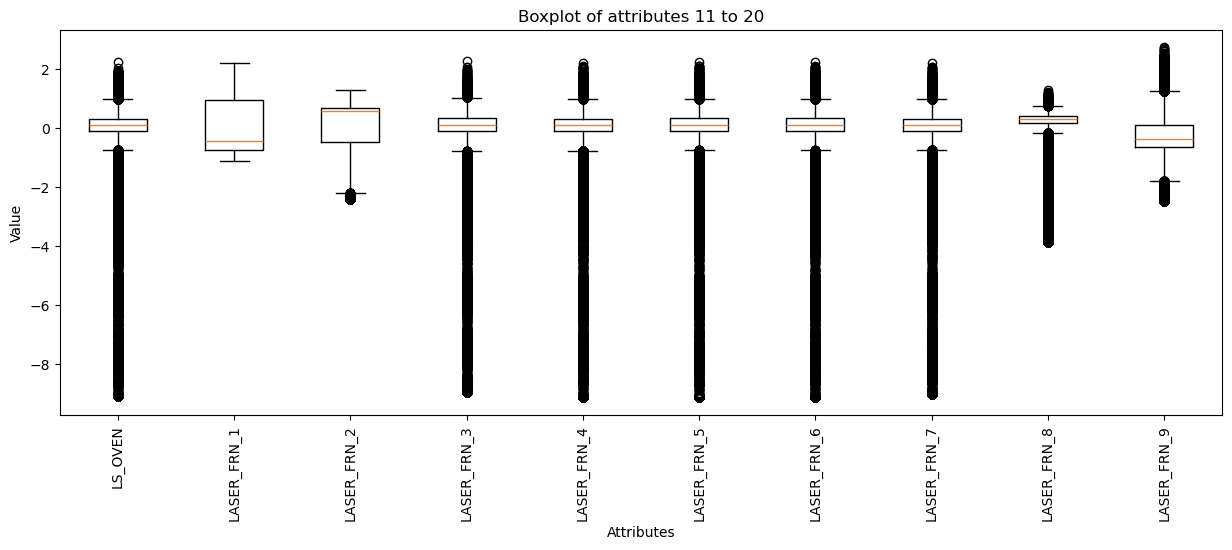

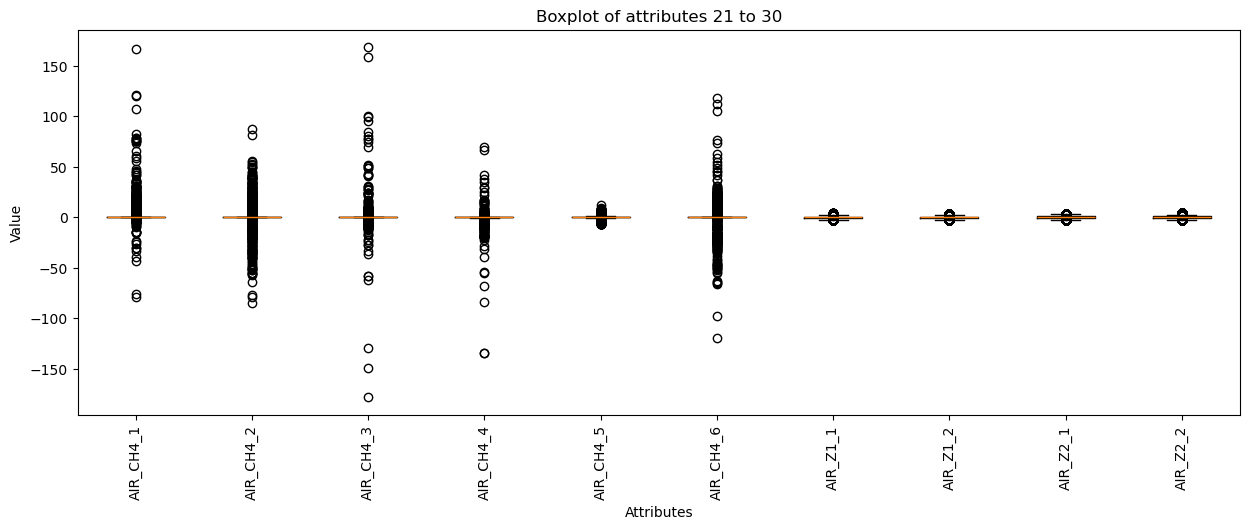

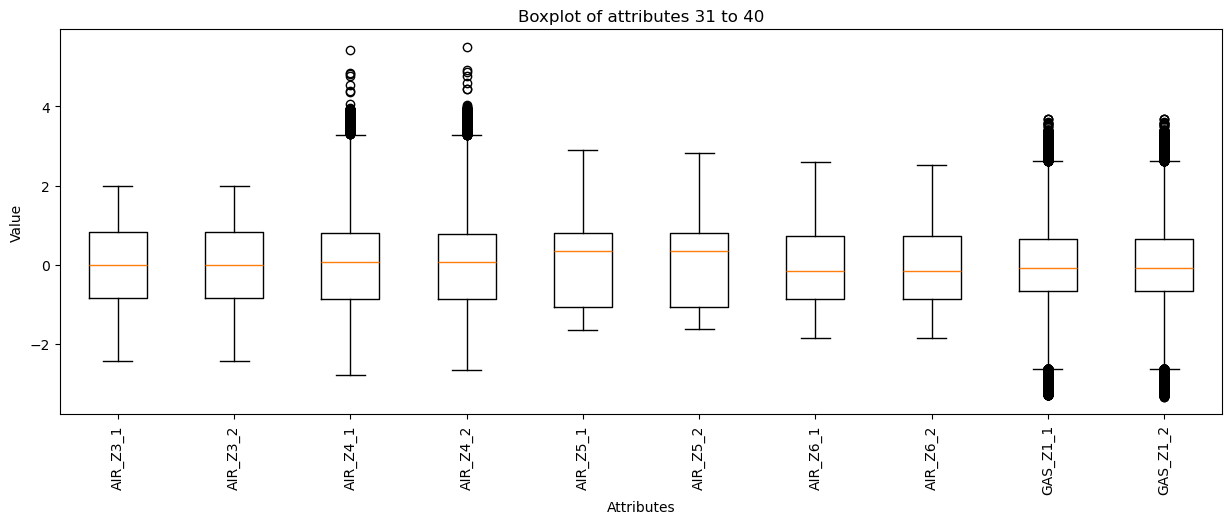

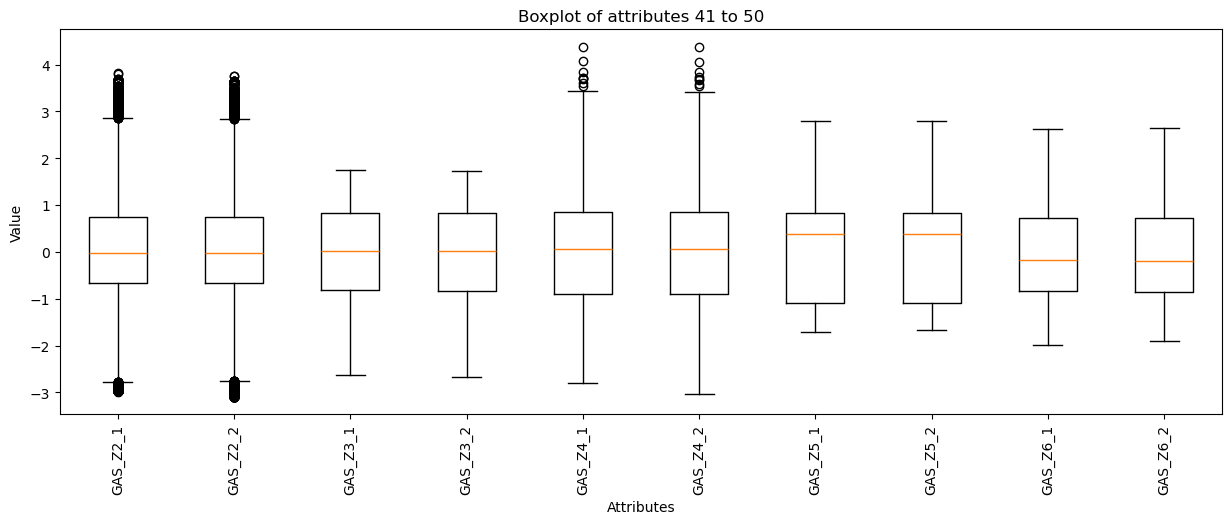

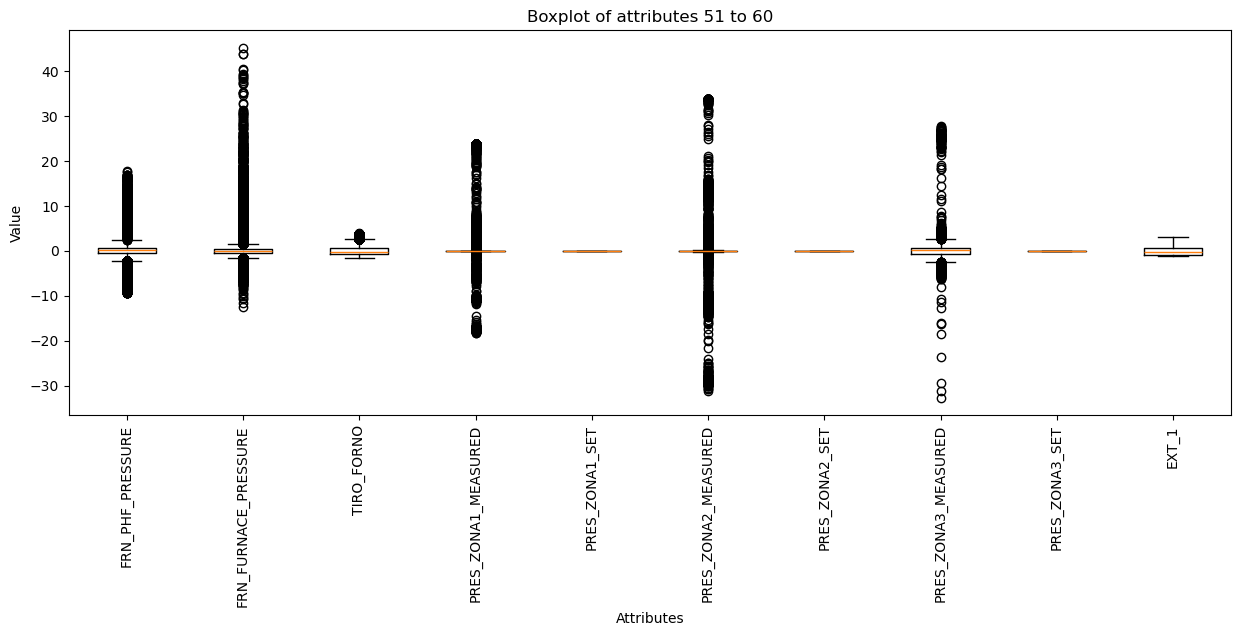

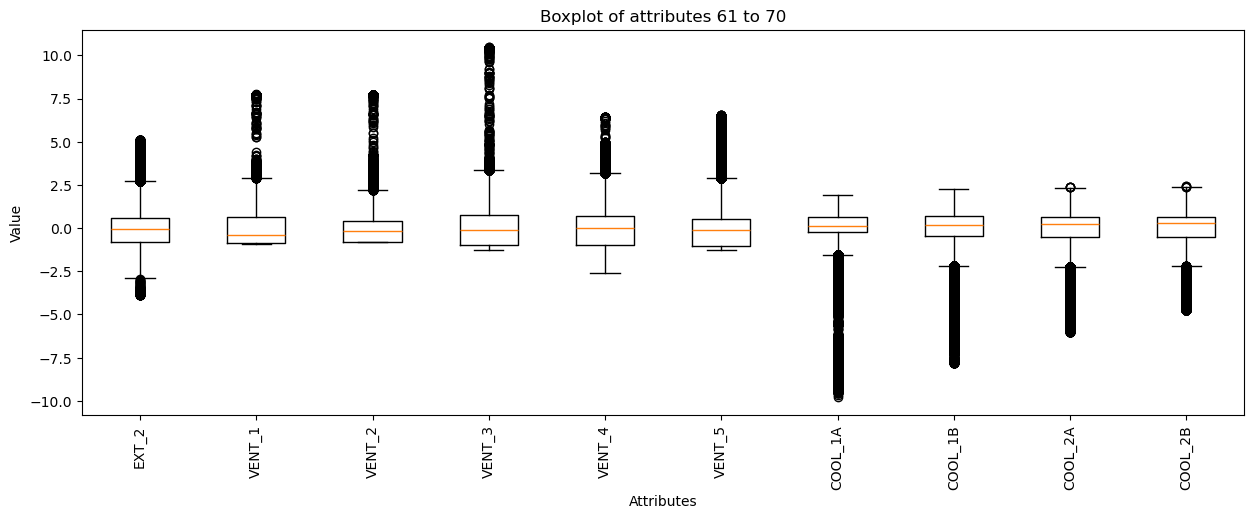

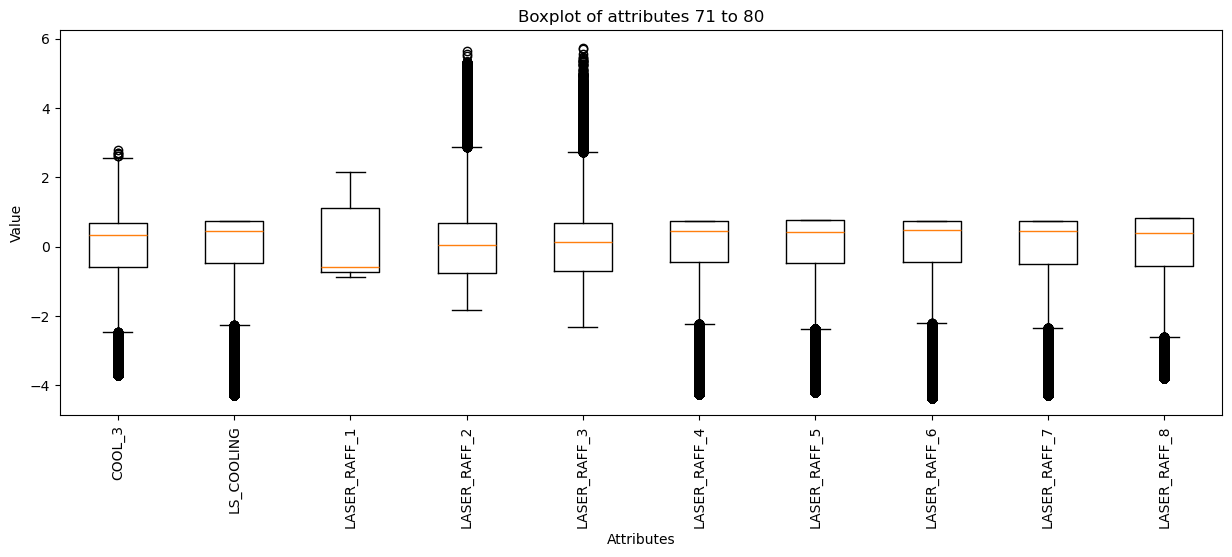

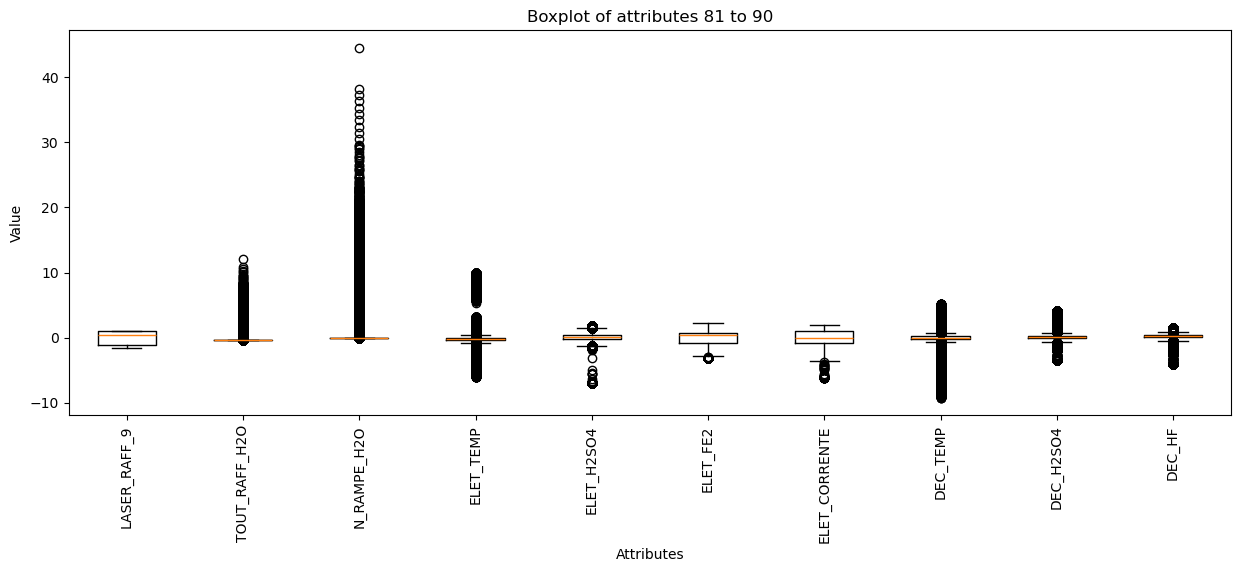

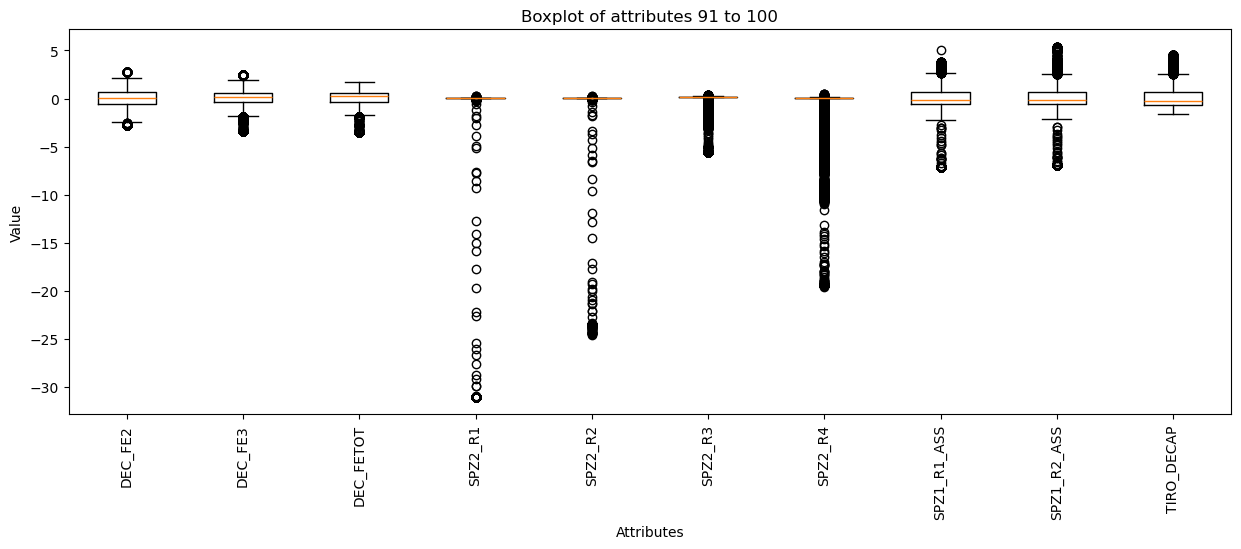

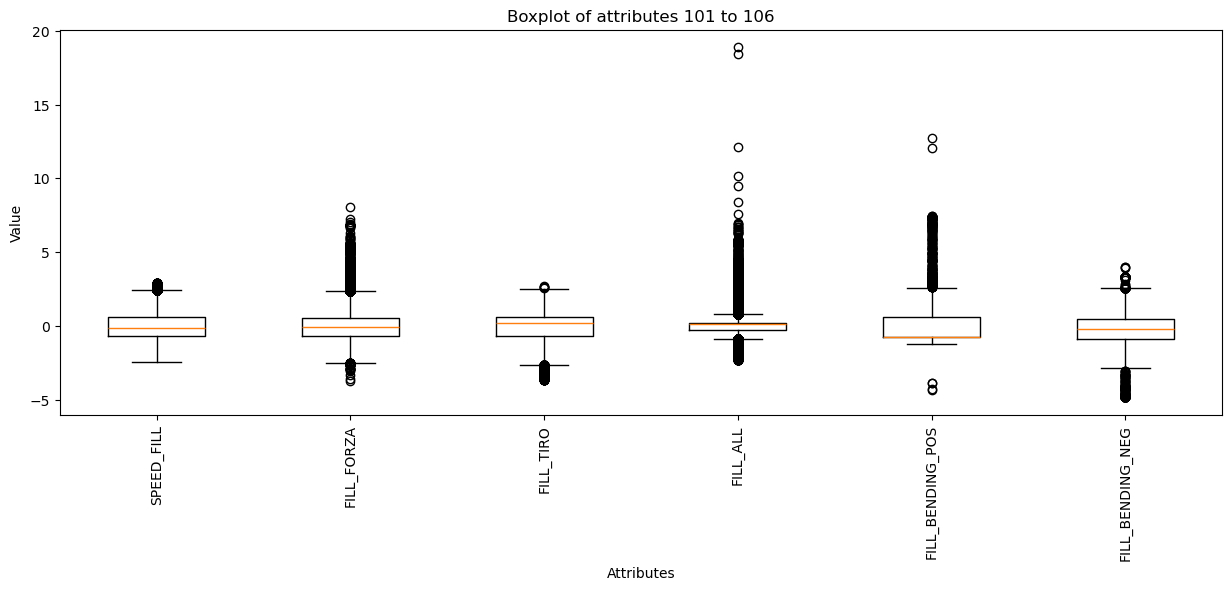

In [22]:
num_attributes = X_std.shape[1]
num_plots = 10  # Number of attributes to plot at a time
num_figures = int(np.ceil(num_attributes / num_plots))

for i in range(num_figures):
    start_idx = i * num_plots
    end_idx = min((i + 1) * num_plots, num_attributes)
    plt.figure(figsize=(15, 5))  # Adjust the size as needed
    plt.boxplot(X_std.iloc[:, start_idx:end_idx])
    plt.title(f'Boxplot of attributes {start_idx + 1} to {end_idx}')
    plt.xlabel('Attributes')
    plt.ylabel('Value')
    plt.xticks(ticks=np.arange(1, end_idx - start_idx + 1), labels=X_std.columns[start_idx:end_idx], rotation=90)
    plt.show()

## Dropping features with PCA

First the correlation between features

Dropping columns with 0 variance

In [23]:
# Calculate the standard deviation for each column and identify columns with zero variance
zero_variance_columns = X_std.std(axis=0) == 0

# Check if there are any columns with zero variance
if zero_variance_columns.any():
    print("Some columns have zero variance and will be dropped.")
    # Drop columns with zero variance
    X_std = X_std.loc[:, ~zero_variance_columns]
print(X_std.shape)

Some columns have zero variance and will be dropped.
(260638, 103)


In [24]:
# Apply PCA
pca = PCA()
pca.fit(X_std)

# Eigenvalues are in the explained_variance_ attribute
eigenvalues = pca.explained_variance_

# Print the eigenvalues for each principal component
for i, eigenvalue in enumerate(eigenvalues, start=1):
    print(f"Eigenvalue for principal component {i}: {eigenvalue}")

# If you want to display the eigenvalues along with the proportion of variance they explain:
for i, (eigenvalue, variance_ratio) in enumerate(zip(eigenvalues, pca.explained_variance_ratio_), start=1):
    print(f"Principal Component {i}: Eigenvalue = {eigenvalue}, Explained Variance Ratio = {variance_ratio:.4f}")


Eigenvalue for principal component 1: 34.48223813795951
Eigenvalue for principal component 2: 10.412937639502111
Eigenvalue for principal component 3: 8.153123840052668
Eigenvalue for principal component 4: 4.612146684032487
Eigenvalue for principal component 5: 3.4302326687713887
Eigenvalue for principal component 6: 2.9698836719546238
Eigenvalue for principal component 7: 2.8898633712560606
Eigenvalue for principal component 8: 2.3671140936314856
Eigenvalue for principal component 9: 2.225029251645607
Eigenvalue for principal component 10: 2.066024403749655
Eigenvalue for principal component 11: 1.8521861631043672
Eigenvalue for principal component 12: 1.6808478833377323
Eigenvalue for principal component 13: 1.6374079162678163
Eigenvalue for principal component 14: 1.5093569574166605
Eigenvalue for principal component 15: 1.2844838411493855
Eigenvalue for principal component 16: 1.2272321618829245
Eigenvalue for principal component 17: 1.1296548816817216
Eigenvalue for principal com

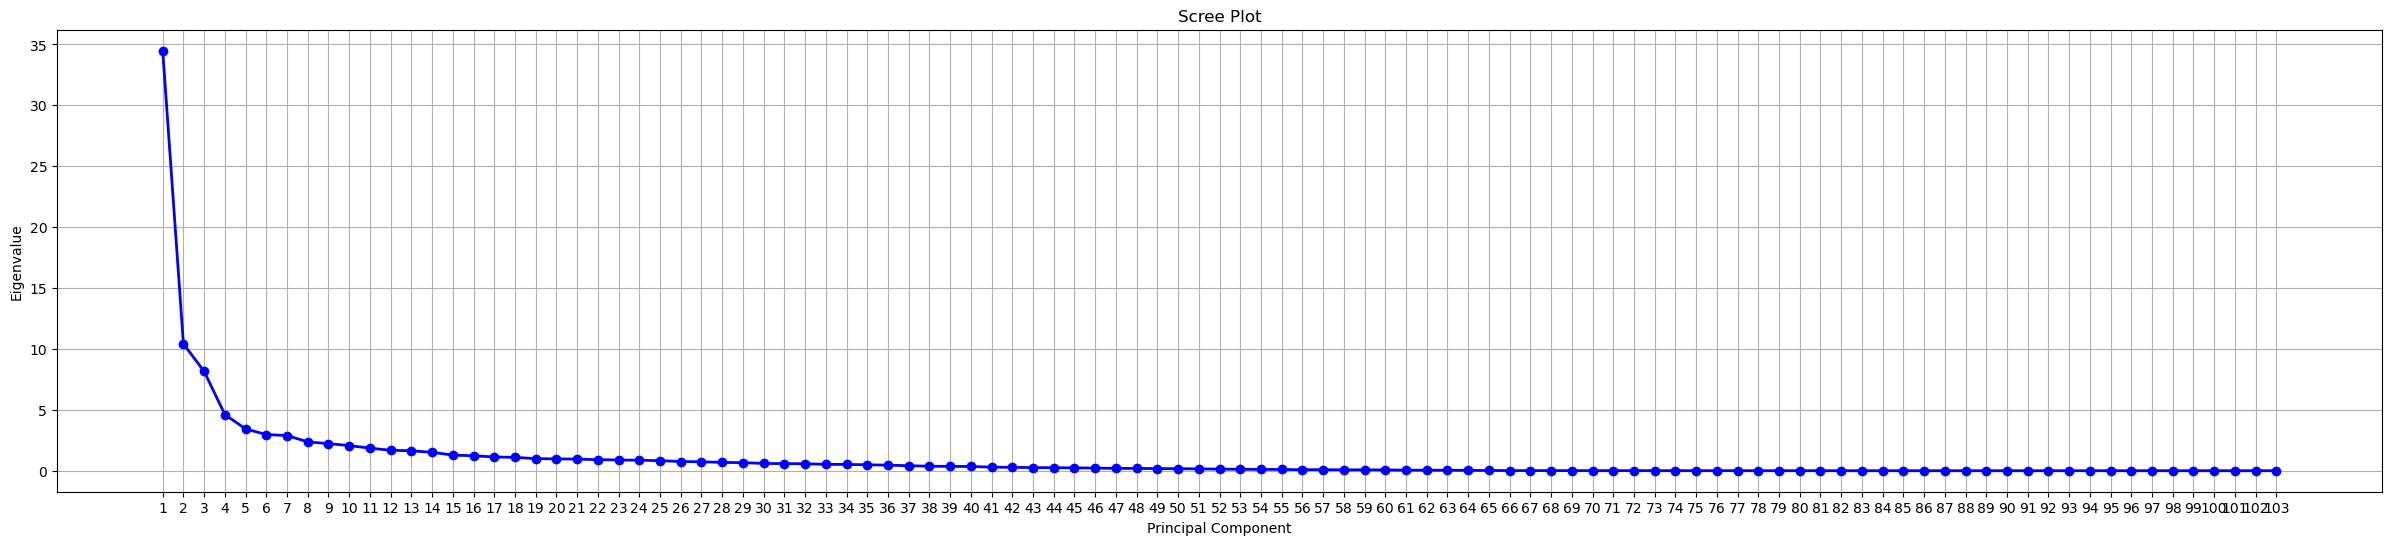

In [25]:
# Create a scree plot of the eigenvalues
plt.figure(figsize=(30, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.xticks(range(1, len(eigenvalues) + 1))  # Add integer ticks for components
plt.show()


In [35]:

correlation_matrix = np.corrcoef(X_std, rowvar=False)
cumulative_eigenvalues = np.cumsum(eigenvalues)
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

# Sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Calculate the differences between successive eigenvalues
eigenvalue_diffs = np.diff(eigenvalues)

# Add a zero at the end of differences to make the array the same length as eigenvalues
eigenvalue_diffs = np.append(eigenvalue_diffs, 0)

cumulative_eigenvalues = np.cumsum(eigenvalues)
cumulative_eigenvalues_percentage = (cumulative_eigenvalues / eigenvalues.sum()) * 100

eigenvalue_table = pd.DataFrame({
    'Eigenvalue': eigenvalues,
    'Difference': eigenvalue_diffs,
    'Cumulative Eigenvalue (%)': cumulative_eigenvalues_percentage
})

eigenvalue_table.head(60)

,Eigenvalue,Difference,Cumulative Eigenvalue (%)
0,34.482106,-24.069208,33.477773
1,10.412898,-2.259805,43.587382
2,8.153093,-3.540964,51.503006
3,4.612129,-1.181909,55.980801
4,3.430220,-0.460347,59.311111
5,2.969872,-0.080020,62.194482
6,2.889852,-0.522747,65.000164
7,2.367105,-0.142084,67.298324
8,2.225021,-0.159004,69.458539
9,2.066016,-0.213837,71.464380


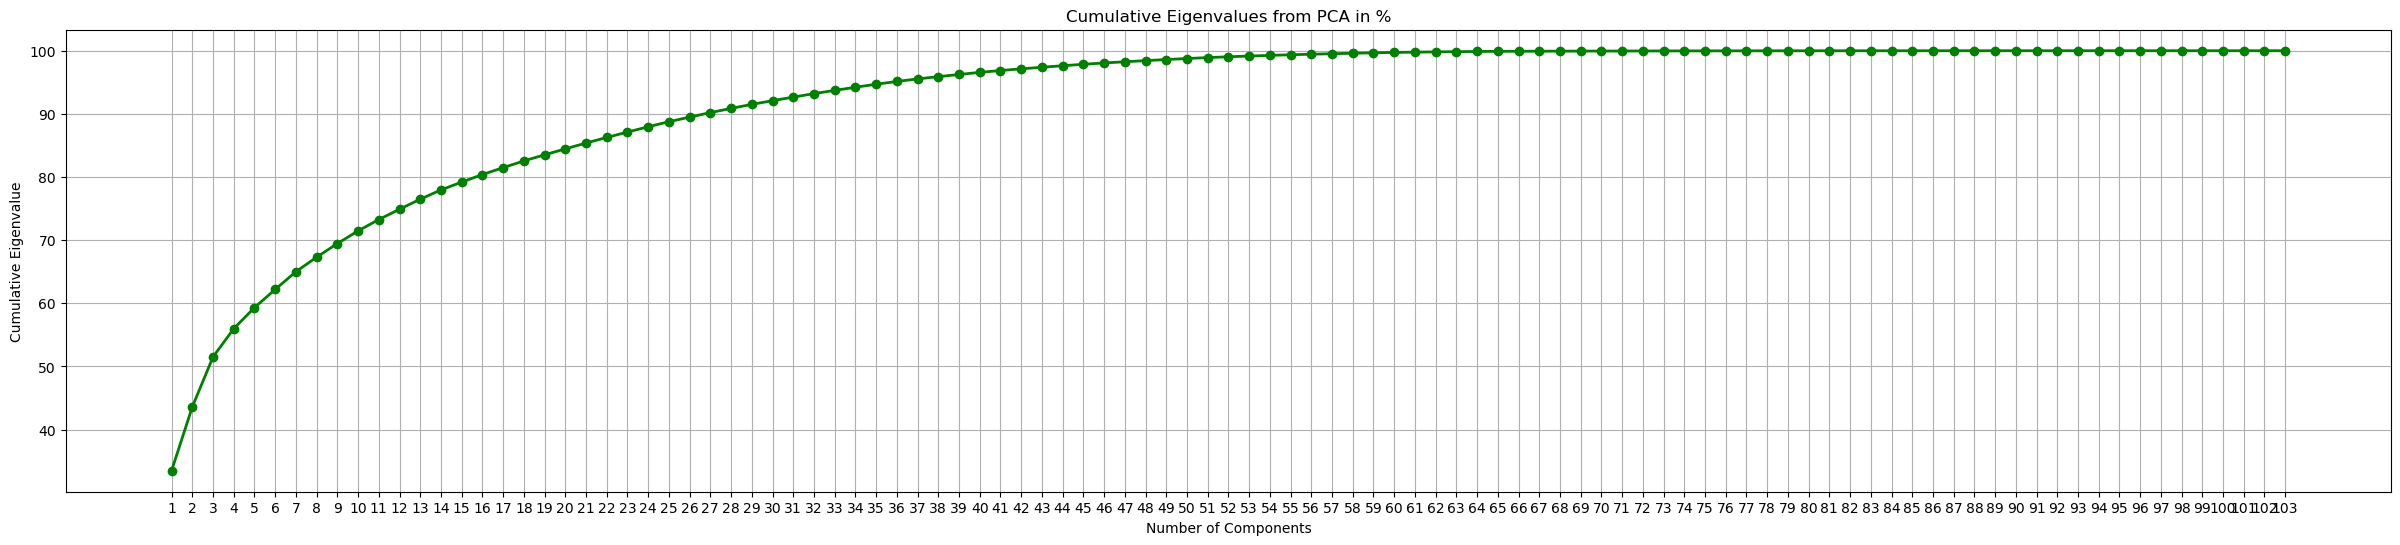

In [32]:
# Plot the cumulative eigenvalues
plt.figure(figsize=(30, 6))
plt.plot(range(1, len(cumulative_eigenvalues_percentage) + 1), cumulative_eigenvalues_percentage, 'o-', linewidth=2, color='green')
plt.title('Cumulative Eigenvalues from PCA in %')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Eigenvalue')
plt.grid(True)
plt.xticks(range(1, len(cumulative_eigenvalues_percentage) + 1))  # Add integer ticks for componentsplt.show()

In [42]:
feature_columns = X_std.columns.tolist()

loadings = pca.components_[:17]

loadings_df = pd.DataFrame(loadings.T, index=feature_columns, columns=[f'PC{i+1}' for i in range(17)])

loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
SPEED_PROCESS,0.012551,-0.099816,0.115329,0.161764,-0.071619,-0.228776,-0.116039,-0.218759,0.176176,-0.068225,0.065399,0.242001,-0.075291,-0.048729,0.006027,0.143084,0.040977
TEMP_Z1,-0.119193,-0.175373,0.079852,-0.031076,-0.030602,-0.001178,-0.026662,0.011765,0.104935,0.005156,-0.128736,-0.059205,-0.034631,0.041476,-0.028680,-0.015830,0.009758
TEMP_Z2,-0.120894,-0.180304,0.072743,-0.025554,-0.018855,0.010239,-0.014460,0.016452,0.074440,0.011888,-0.106277,-0.051624,-0.046736,0.026186,-0.032789,0.003749,0.024045
TEMP_Z3,-0.118015,-0.188124,0.075361,-0.031460,-0.013815,0.011529,-0.010215,0.014814,0.069192,0.013709,-0.102067,-0.045052,-0.043519,0.024953,-0.026429,0.006793,0.021587
TEMP_Z4,-0.119242,-0.188070,0.088290,-0.012400,0.030221,0.031487,0.031358,0.033708,-0.040891,0.016961,-0.015367,-0.016776,-0.049035,0.010177,-0.026402,0.003725,0.017359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FILL_FORZA,-0.050818,0.066348,-0.008856,-0.155176,-0.085815,0.268447,0.145183,0.035145,0.055784,-0.106753,-0.050509,-0.135628,-0.126240,0.111683,0.065063,0.097679,0.035411
FILL_TIRO,-0.092335,0.109662,-0.064317,-0.118207,-0.093371,0.041547,-0.056037,-0.073899,0.034403,-0.093732,0.078981,0.024865,-0.182007,-0.131798,0.063267,-0.039198,-0.026746
FILL_ALL,0.025747,-0.022268,0.053630,-0.097384,0.026327,0.142146,0.069896,-0.111970,0.065621,-0.229578,0.117869,-0.035608,-0.425180,-0.095554,0.008357,-0.238380,-0.053571
FILL_BENDING_POS,0.036231,-0.040785,-0.003177,0.154448,0.019074,-0.190917,-0.106850,0.141536,-0.203531,0.251064,-0.099612,-0.071416,0.379356,0.069634,0.020326,0.032192,-0.067493


In [48]:
# Assuming 'pca' is your fitted PCA object and 'feature_columns' contains the names of the numeric features
num_components = 36
loadings = pca.components_[:num_components]

# Create a dictionary to store DataFrames for each principal component
pcs_contributions = {}

for i in range(num_components):
    # Square the loadings to get the loading scores
    loading_scores = loadings[i] ** 2
    
    # Normalize the loading scores to get the percentage contribution
    loading_scores_normalized = loading_scores / loading_scores.sum()
    
    # Convert to percentage
    loading_scores_percentage = loading_scores_normalized * 100
    
    # Create a DataFrame with the percentage contribution of each feature to the current PC
    contributions_df = pd.DataFrame({
        'Feature': feature_columns,
        f'Contribution to PC{i+1} (%)': loading_scores_percentage
    })
    
    # Sort the DataFrame by contribution in descending order
    contributions_df_sorted = contributions_df.sort_values(by=f'Contribution to PC{i+1} (%)', ascending=False)
    
    # Add the sorted DataFrame to the dictionary
    pcs_contributions[f'PC{i+1}'] = contributions_df_sorted

# Now you have 17 DataFrames, each sorted by the contribution to the respective principal component
# You can access each one using the keys 'PC1', 'PC2', ..., 'PC17'
# For example, to view the contributions sorted for PC2, you can do:
print(pcs_contributions['PC2'])

# If you want to export each DataFrame to a different sheet in an Excel file:
with pd.ExcelWriter('pcs_contributions.xlsx') as writer:
    for pc, df in pcs_contributions.items():
        df.to_excel(writer, sheet_name=pc, index=False)


        Feature  Contribution to PC2 (%)
15  LASER_FRN_5             4.775990e+00
16  LASER_FRN_6             4.757871e+00
14  LASER_FRN_4             4.726933e+00
10      LS_OVEN             4.681642e+00
17  LASER_FRN_7             4.639810e+00
..          ...                      ...
85    DEC_H2SO4             1.371380e-03
79  N_RAMPE_H2O             7.419037e-04
89    DEC_FETOT             2.106276e-04
81   ELET_H2SO4             1.340240e-06
82     ELET_FE2             1.264545e-07

[103 rows x 2 columns]


In [52]:

# Assuming 'pca' is your fitted PCA object and 'feature_columns' contains the names of the numeric features
num_components = 36
loadings = pca.components_[:num_components]

# Create an empty DataFrame to store the sum of contributions for each feature
feature_contribution_sums = pd.DataFrame(index=feature_columns, columns=['Sum of Contributions (%)'])

# Initialize the sum of contributions to zero
feature_contribution_sums['Sum of Contributions (%)'] = 0

for i in range(num_components):
    # Square the loadings to get the loading scores
    loading_scores = loadings[i] ** 2
    
    # Normalize the loading scores to get the percentage contribution
    loading_scores_normalized = loading_scores / loading_scores.sum()
    
    # Convert to percentage
    loading_scores_percentage = loading_scores_normalized * 100
    
    # Add the contributions to the sum for each feature
    feature_contribution_sums['Sum of Contributions (%)'] += loading_scores_percentage

# Now, feature_contribution_sums contains the sum of percentage contributions across the first 17 PCs
print(feature_contribution_sums)

# Optionally, sort the DataFrame by the sum of contributions in descending order
feature_contribution_sums_sorted = feature_contribution_sums.sort_values(by='Sum of Contributions (%)', ascending=False)
feature_contribution_sums_sorted

                  Sum of Contributions (%)
SPEED_PROCESS                    31.912631
TEMP_Z1                          14.408020
TEMP_Z2                          14.334819
TEMP_Z3                          13.277626
TEMP_Z4                          10.716380
...                                    ...
FILL_FORZA                       56.460605
FILL_TIRO                        28.696105
FILL_ALL                         67.386192
FILL_BENDING_POS                 43.559937
FILL_BENDING_NEG                 61.989704

[103 rows x 1 columns]


,Sum of Contributions (%)
AIR_CH4_6,99.973354
AIR_CH4_3,99.935917
AIR_CH4_2,99.690719
AIR_CH4_1,98.516158
FRN_FURNACE_PRESSURE,96.245550
...,...
COOL_2B,8.935971
AIR_Z3_2,6.597849
AIR_Z3_1,6.592337
GAS_Z3_2,6.350444


## Splitting into Training, Validation and Test

In [65]:
feature_columns = [col for col in dropped_df.columns if col not in ['COIL', 'DATE', 'MT_REVIEWED', 'TIME_START_PROCESS', 'DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']]
target_columns = ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6']

X = dropped_df[feature_columns]
y = dropped_df[target_columns]

# Group by 'COIL' and create a list of indices for each group
grouped = dropped_df.groupby('COIL').groups

# Convert the groups to a list of dataframes
grouped_indices = [grouped[key] for key in grouped]

# Split the grouped indices into train and temp (which will be further split into validate and test)
train_indices, temp_indices = train_test_split(grouped_indices, test_size=0.4, random_state=42)

# Further split temp into validate and test
validate_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Now flatten the list of indices for each subset
train_indices = [index for sublist in train_indices for index in sublist]
validate_indices = [index for sublist in validate_indices for index in sublist]
test_indices = [index for sublist in test_indices for index in sublist]

# Use the indices to create the actual subsets
X_train, y_train = X.loc[train_indices], y.loc[train_indices]
X_validate, y_validate = X.loc[validate_indices], y.loc[validate_indices]
X_test, y_test = X.loc[test_indices], y.loc[test_indices]

# Now you have X_train, y_train, X_validate, y_validate, X_test, y_test
# with the guarantee that no 'COIL' ID is in more than one subset


In [66]:
print('There are {} samples in the training dataset which represent the {:.2f}%'.format(X_train.shape[0], X_train.shape[0]/dropped_df.shape[0]*100))
print("There are {} samples in the validating dataset which represent the {:.2f}%".format(X_validate.shape[0], X_validate.shape[0]/dropped_df.shape[0]*100))
print("There are {} samples in the testing dataset which represent the {:.2f}%".format(X_test.shape[0], X_test.shape[0]/dropped_df.shape[0]*100))
print("Each sample has {} features".format(X_train.shape[1]))
print(f"Unique COIL values in 'production' dataset: {production['COIL'].nunique()}")
print(f"Unique COIL values in 'dropped_df' dataset: {dropped_df['COIL'].nunique()}")

There are 154259 samples in the training dataset which represent the 59.19%
There are 51293 samples in the validating dataset which represent the 19.68%
There are 55086 samples in the testing dataset which represent the 21.14%
Each sample has 106 features
Unique COIL values in 'production' dataset: 1261
Unique COIL values in 'dropped_df' dataset: 1214


In [67]:
coil_to_dataset = {}

for coil_id in dropped_df['COIL'].unique():
    if coil_id in dropped_df.loc[train_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'train'
    elif coil_id in dropped_df.loc[validate_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'validate'
    elif coil_id in dropped_df.loc[test_indices, 'COIL'].values:
        coil_to_dataset[coil_id] = 'test'
from collections import defaultdict
coil_datasets = defaultdict(list)

for coil_id, dataset in coil_to_dataset.items():
    coil_datasets[coil_id].append(dataset)
duplicates = {coil_id: datasets for coil_id, datasets in coil_datasets.items() if len(datasets) > 1}
if duplicates:
    print("Duplicate COIL IDs found in multiple datasets:", duplicates)
else:
    print("No duplicate COIL IDs found. The split is correct.")


No duplicate COIL IDs found. The split is correct.


### Distribution of errors after splitting

In [73]:
train_error_counts = y_train.sum(axis=0)
validate_error_counts = y_validate.sum(axis=0)
test_error_counts = y_test.sum(axis=0)

# Calculate the total number of defects for each split
total_train_errors = train_error_counts.sum()
total_validate_errors = validate_error_counts.sum()
total_test_errors = test_error_counts.sum()

# Calculate the percentage of each defect type for each split and round to 2 decimals
train_error_percentages = ((train_error_counts / total_train_errors) * 100).round(2)
validate_error_percentages = ((validate_error_counts / total_validate_errors) * 100).round(2)
test_error_percentages = ((test_error_counts / total_test_errors) * 100).round(2)

# Create a DataFrame with the counts and percentages
error_counts_df = pd.DataFrame({
    'Error Type': ['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6'],
    'Training Set Count': train_error_counts.values,
    'Training Set %': train_error_percentages.values,
    'Validating Set Count': validate_error_counts.values,
    'Validating Set %': validate_error_percentages.values,
    'Testing Set Count': test_error_counts.values,
    'Testing Set %': test_error_percentages.values,
})

# Print the DataFrame
error_counts_df


,Error Type,Training Set Count,Training Set %,Validating Set Count,Validating Set %,Testing Set Count,Testing Set %
0,DIF_TIPO_1,4765,5.11,661,2.51,748,2.20
1,DIF_TIPO_2,5208,5.59,886,3.37,2584,7.59
2,DIF_TIPO_3,49258,52.84,12993,49.35,15674,46.02
3,DIF_TIPO_4,26899,28.85,8762,33.28,11911,34.97
4,DIF_TIPO_5,3079,3.30,2151,8.17,1450,4.26
5,DIF_TIPO_6,4019,4.31,875,3.32,1689,4.96


### Multilabel target

In [75]:
# Initialize the Random Forest classifier with default parameters
rf_classifier = RandomForestClassifier(random_state=random_state)

# Since you have a multilabel target, wrap the classifier with MultiOutputClassifier
multi_target_rf = MultiOutputClassifier(rf_classifier, n_jobs=-1)

# Fit the model to the training data
multi_target_rf.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = multi_target_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_hamming_loss = hamming_loss(y_train, y_train_pred)

# Make predictions on the validation set
y_val_pred = multi_target_rf.predict(X_validate)
val_accuracy = accuracy_score(y_validate, y_val_pred)
val_hamming_loss = hamming_loss(y_validate, y_val_pred)

# Make predictions on the test set
y_test_pred = multi_target_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_hamming_loss = hamming_loss(y_test, y_test_pred)

# Print the results
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Hamming Loss: {train_hamming_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Hamming Loss: {val_hamming_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Hamming Loss: {test_hamming_loss:.4f}")


Train Accuracy: 1.0000
Train Hamming Loss: 0.0000
Validation Accuracy: 0.7141
Validation Hamming Loss: 0.0687
Test Accuracy: 0.6677
Test Hamming Loss: 0.0815


In [74]:
# # This model is taking more than 90 minutes
# # Define the parameter grid for Random Forest
# param_grid = {
#     'estimator__n_estimators': [50, 100],          # Reduced number of trees [100, 150, 200]
#     'estimator__max_depth': [5, 10],               # Reduced depth of trees [10, 20, 30, None]
#     'estimator__min_samples_split': [2, 5],
#     'estimator__min_samples_leaf': [1, 2],
#     'estimator__max_features': ['sqrt', 'log2'],
#     'estimator__bootstrap': [True]
# }

# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(random_state=random_state)

# # Since you have a multilabel target, wrap the classifier with MultiOutputClassifier
# multi_target_rf = MultiOutputClassifier(rf_classifier)

# # Create a scorer that uses hamming_loss as the evaluation metric
# hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)

# # Initialize GridSearchCV with the Random Forest classifier and the parameter grid
# grid_search = GridSearchCV(multi_target_rf, param_grid, cv=2, scoring=hamming_scorer, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the corresponding score
# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_  # Negate because greater_is_better=False

# print(f"Best parameters: {best_params}")
# print(f"Best Hamming Loss (lower is better): {best_score:.4f}")

# # You can use the best estimator directly to make predictions
# best_model = grid_search.best_estimator_

# # Make predictions with the best model
# y_validate_pred = best_model.predict(X_validate)

# # Calculate the Hamming loss for the validation set
# validate_hamming_loss = hamming_loss(y_validate, y_validate_pred)

# print(f"Validation Set Hamming Loss: {validate_hamming_loss:.4f}")


KeyboardInterrupt: 

In [43]:
# Decision Tree CLF
clf = DecisionTreeClassifier(random_state=random_state)
multioutput_clf = MultiOutputClassifier(clf, n_jobs=-1)
param_grid = {
    'estimator__max_depth': [5, 10, None],  # Example depths
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2', None]  # Include None for considering all features
}

hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=multioutput_clf,
    param_grid=param_grid,
    cv=2,  # Reduced from 3 to 2
    n_jobs=-1,
    verbose=2,
    scoring=hamming_scorer
)
grid_search.fit(X_train, y_train)


# Random Forest CLF
clf = RandomForestClassifier(random_state=random_state)
multioutput_clf = MultiOutputClassifier(clf, n_jobs=-1)
param_grid = {
    'estimator__n_estimators': [50, 100],          # Reduced number of trees [100, 150, 200]
    'estimator__max_depth': [5, 10],               # Reduced depth of trees [10, 20, 30, None]
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2'],
    'estimator__bootstrap': [True]
}
hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=multioutput_clf, 
    param_grid=param_grid, 
    cv=2,                               # Reduced from 3 to 2
    n_jobs=-1, 
    verbose=2)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_



# Random Search CV 
random_search = RandomizedSearchCV(        
    multioutput_clf,
    param_distributions=param_grid,
    n_iter=5,                           # Reduced from 10 to 5
    cv=2,                               # Reduced from 3 to 2
    n_jobs=-1,
    verbose=2,
    scoring=hamming_scorer,
    random_state=random_state
)
random_search.fit(X_train, y_train)
best_pipeline = random_search.best_estimator_



Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2; total time=   5.4s
[CV] END estimator__max_depth=5, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2; total time=   5.6s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2; total time=   7.2s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2; total time=   7.2s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5; total time=   7.2s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2; total time=   7.3s
[CV] END estimator__max_depth=5, estimator__max_features=sqrt, estima

GridSearchCV(cv=2,
             estimator=MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                             n_jobs=-1),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [5, 10, None],
                         'estimator__max_features': ['sqrt', 'log2', None],
                         'estimator__min_samples_leaf': [1, 2],
                         'estimator__min_samples_split': [2, 5]},
             scoring=make_scorer(hamming_loss, greater_is_better=False, response_method='predict'),
             verbose=2)

### For multilable target

In [224]:
best_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
# Assuming you have already made predictions on the test set with your best model
y_pred = best_clf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate the Hamming loss (the lower, the better)
hammingloss = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hammingloss:.4f}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['DIF_TIPO_1', 'DIF_TIPO_2', 'DIF_TIPO_3', 'DIF_TIPO_4', 'DIF_TIPO_5', 'DIF_TIPO_6'])
print(report)

# If you want to calculate other metrics, such as precision, recall, and F1-score for each label, you can do so as follows:
precision = precision_score(y_test, y_pred, average=None, zero_division=0)  # Returns precision for each label
recall = recall_score(y_test, y_pred, average=None)        # Returns recall for each label
f1 = f1_score(y_test, y_pred, average=None)                # Returns F1 score for each label

print(f"Precision per label: {precision}")
print(f"Recall per label: {recall}")
print(f"F1 Score per label: {f1}")

# To get a single summary metric for precision, recall, and F1-score, you can use average='micro', 'macro', or 'weighted':
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")

# Micro-average will aggregate the contributions of all classes to compute the average metric
precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)

print(f"Micro Precision: {precision_micro:.4f}")
print(f"Micro Recall: {recall_micro:.4f}")
print(f"Micro F1 Score: {f1_micro:.4f}")

# Weighted-average will account for class imbalance by computing the average of precision, recall, and F1-score, weighted by the number of true instances for each label
precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")


Accuracy: 0.9928
Hamming Loss: 0.0072


ValueError: Number of classes, 2, does not match size of target_names, 6. Try specifying the labels parameter

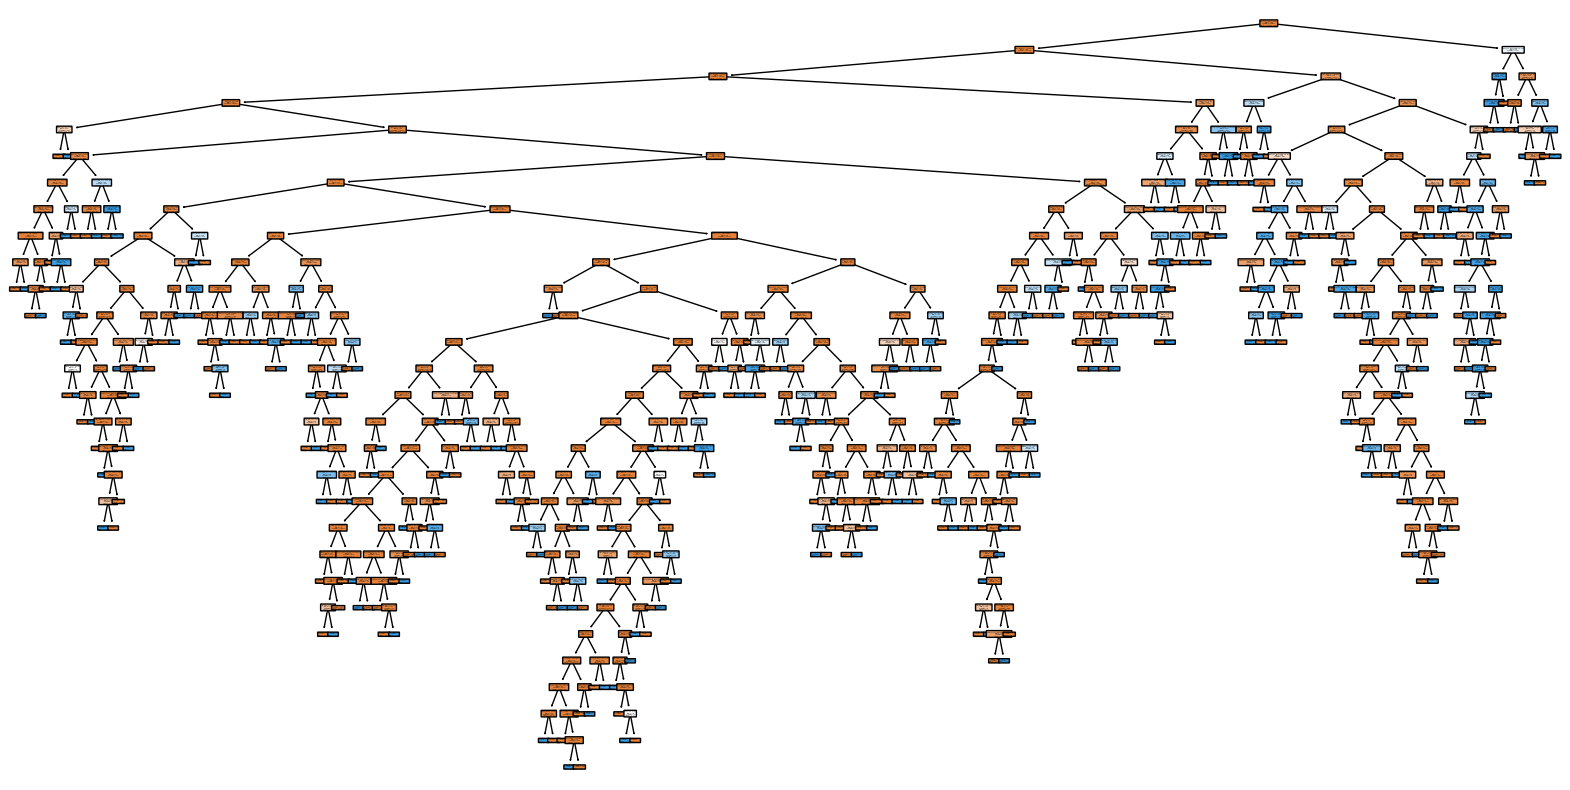

In [24]:
# #For showing the Decision Tree
# single_tree = best_clf.estimators_[0]  # Index 0 for the first label, for example
# feature_names_list = X_train.columns.tolist()

# # Plot the decision tree
# plt.figure(figsize=(20, 10))  # Set the figure size (width, height) in inches
# plot_tree(single_tree, 
#           filled=True, 
#           feature_names=feature_names_list, 
#           rounded=True, 
#           proportion=False, 
#           precision=2)
# plt.show()


## Built-in Feature Importance
Most tree-based models in libraries like scikit-learn have a built-in feature_importances_ attribute after the model has been fitted. This provides a simple way to see the relative importance of each feature

In [25]:
importances = best_clf.estimators_[0].feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Feature SPZ1_R2_ASS (0.093227)
2. Feature TIRO_DECAP (0.088273)
3. Feature FRN_PHF_PRESSURE (0.082390)
4. Feature ELET_H2SO4 (0.071826)
5. Feature VENT_5 (0.064574)
6. Feature SPEED_PROCESS (0.057340)
7. Feature TOUT_RAFF_H2O (0.040781)
8. Feature DEC_H2SO4 (0.039393)
9. Feature VENT_2 (0.032966)
10. Feature SPZ1_R1_ASS (0.031836)
11. Feature PYRO_3_LST_3_ZONE (0.028152)
12. Feature EXT_1 (0.025559)
13. Feature ELET_FE2 (0.023553)
14. Feature LASER_FRN_2 (0.021092)
15. Feature FILL_FORZA (0.019360)
16. Feature DEC_TEMP (0.018354)
17. Feature VENT_3 (0.016046)
18. Feature TEMP_Z3 (0.014826)
19. Feature AIR_Z3_1 (0.013799)
20. Feature LASER_FRN_3 (0.013639)
21. Feature DEC_FE2 (0.013636)
22. Feature DEC_FETOT (0.012080)
23. Feature GAS_Z2_1 (0.010687)
24. Feature PYRO_2_FRST_3_ZONE (0.010510)
25. Feature FILL_TIRO (0.009855)
26. Feature LS_OVEN (0.009528)
27. Feature ELET_CORRENTE (0.008570)
28. Feature DEC_HF (0.007933)
29. Feature FILL_ALL (0.007924)
30. Feature SPZ

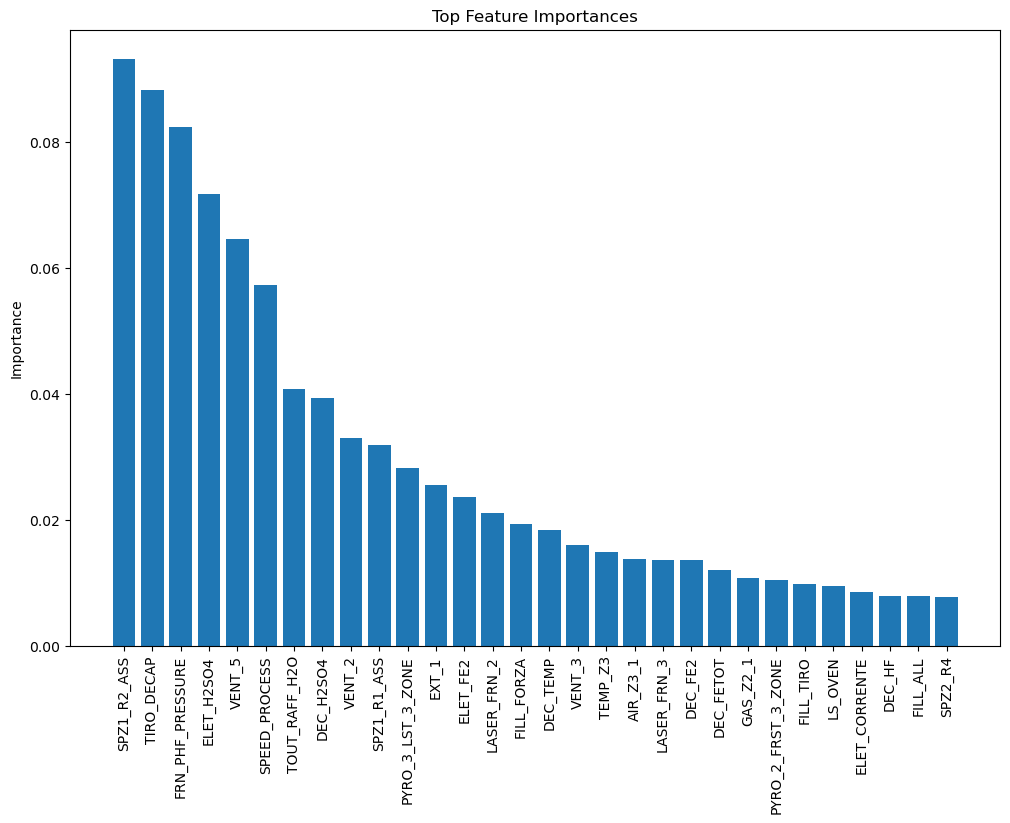

In [122]:
# Number of features to show on the plot
top_n_features = 30  # You can set this to X_train.shape[1] to show all features

# Get the indices of the top N features
top_indices = indices[:top_n_features]

# Now, plot the importances
plt.figure(figsize=(12, 8))
plt.title("Top Feature Importances")
plt.bar(range(top_n_features), importances[top_indices], align="center")

# Add the feature names as x-axis labels
plt.xticks(range(top_n_features), X_train.columns[top_indices], rotation=90)

# Add the y-axis label
plt.ylabel('Importance')

# Show the plot
plt.show()


In [26]:
# # For export to a csv file
# feature_ranking = []
# # Append the feature ranking information to the list
# for f in range(X_train.shape[1]):
#     feature_ranking.append([f + 1, X_train.columns[indices[f]], importances[indices[f]]])

# # Write the feature ranking information to a CSV file
# with open('feature_ranking.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Rank', 'Feature', 'Importance'])
#     writer.writerows(feature_ranking)

## Permutation Importance
Permutation importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This technique is calculated after a model has been fitted and involves randomly shuffling individual features in the validation set and measuring how the score (like accuracy) decreases. A large decrease in model score signifies the importance of the feature.

In [106]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_clf.estimators_[0], X_test, y_test.iloc[:, 0], n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

for i in sorted_idx[::-1]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f}")


TIRO_DECAP: 0.0524
TIRO_FORNO: 0.0320
ELET_H2SO4: 0.0105
SPEED_PROCESS: 0.0095
SPEED_FILL: 0.0071
SPZ1_R2_ASS: 0.0065
TEMP_Z4: 0.0056
FILL_ALL: 0.0055
AIR_Z1_1: 0.0052
DEC_H2SO4: 0.0050
FILL_FORZA: 0.0044
FILL_TIRO: 0.0044
FRN_PHF_PRESSURE: 0.0043
VENT_5: 0.0038
SPZ1_R1_ASS: 0.0037
LASER_FRN_4: 0.0036
TOUT_RAFF_H2O: 0.0032
TEMP_Z5: 0.0031
ELET_FE2: 0.0029
DEC_FE2: 0.0027
AIR_CH4_2: 0.0025
VENT_2: 0.0025
LASER_FRN_1: 0.0024
GAS_Z6_2: 0.0023
AIR_Z3_1: 0.0022
PYRO_3_LST_3_ZONE: 0.0022
ELET_CORRENTE: 0.0022
DEC_HF: 0.0020
DEC_TEMP: 0.0019
VENT_3: 0.0019
EXT_1: 0.0018
AIR_CH4_3: 0.0018
LASER_FRN_2: 0.0016
ELET_TEMP: 0.0014
LASER_FRN_9: 0.0014
TEMP_Z3: 0.0013
COOL_3: 0.0013
AIR_CH4_4: 0.0013
PRES_ZONA1_MEASURED: 0.0012
VENT_1: 0.0011
GAS_Z6_1: 0.0009
DEC_FETOT: 0.0008
AIR_Z1_2: 0.0008
SPZ2_R4: 0.0006
PYRO_2_FRST_3_ZONE: 0.0006
AIR_CH4_1: 0.0006
GAS_Z3_2: 0.0006
LASER_FRN_8: 0.0006
LASER_RAFF_3: 0.0006
FILL_BENDING_POS: 0.0005
LASER_FRN_3: 0.0005
SPZ2_R3: 0.0005
GAS_Z4_2: 0.0005
PRES_ZONA3_ME

In [28]:
# # Export to excel
# importances_df = pd.DataFrame({
#     'Feature': X_test.columns,
#     'Importance_mean': result.importances_mean,
#     'Importance_std': result.importances_std
# })
# importances_df = importances_df.sort_values(by='Importance_mean', ascending=False).reset_index(drop=True)
# importances_df.to_excel('feature_importances.xlsx', index=False)

## Partial Dependence Plots
Partial dependence plots (PDPs) show the dependence between the target response and a set of 'target' features, marginalizing over the values of all other features. PDPs can show whether the relationship between the target and a feature is linear, monotonic, or more complex.

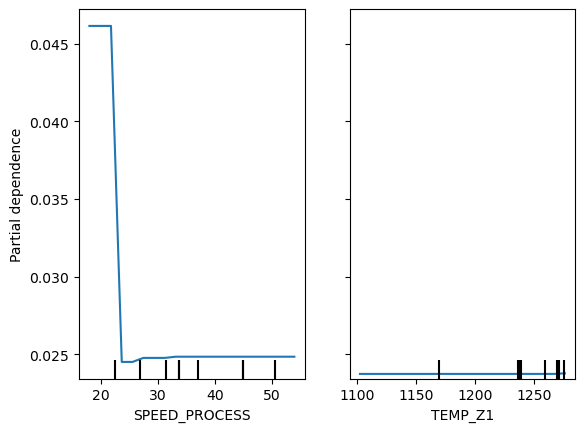

In [29]:
from sklearn.inspection import PartialDependenceDisplay

# Assuming you have a fitted model called 'best_estimator_for_target'
# and you want to plot partial dependence for a specific target (e.g., the first one)
best_estimator_for_target = best_clf.estimators_[0]

# Specify the features for which you want to plot the PDPs
features = [0, 1]  # Replace with the indices or names of the features you are interested in

# Create the partial dependence plot
PartialDependenceDisplay.from_estimator(
    best_estimator_for_target,
    X_train,
    features,
    kind="average",  # or 'individual' or 'both'
    grid_resolution=20  # Number of grid points to use for numeric features
)

# If you want to save the figure, you can do so by accessing the matplotlib axes
import matplotlib.pyplot as plt
plt.savefig('partial_dependence_plot.png')  # Save the plot as a PNG file


## SHAP Values
SHAP (SHapley Additive exPlanations) values break down a prediction to show the impact of each feature. Unlike simple feature importance, SHAP values can show how a feature contributed to each individual prediction, as well as on average. SHAP values can be complex to calculate but provide a very detailed understanding of model behavior.

In [30]:
# Loop over each fitted classifier for each target and create SHAP values
for i, estimator in enumerate(best_clf.estimators_):
    # Create a SHAP explainer for the i-th estimator
    explainer = shap.TreeExplainer(estimator)

    # Calculate SHAP values for the i-th target
    shap_values = explainer.shap_values(X_test)

    # Plot summary plot using SHAP values for the i-th target
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)

    # Save the plot for each target
    plt.savefig(f'shap_summary_plot_target_{i}.png')
    plt.clf()  # Clear the current figure for the next plot


<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

<Figure size 1150x660 with 0 Axes>

Target variable 'DIF_TIPO_1' is NOT present in the features.
Target variable 'DIF_TIPO_2' is NOT present in the features.
Target variable 'DIF_TIPO_3' is NOT present in the features.
Target variable 'DIF_TIPO_4' is NOT present in the features.
Target variable 'DIF_TIPO_5' is NOT present in the features.
Target variable 'DIF_TIPO_6' is NOT present in the features.
